In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter
import geopandas as gpd
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

Northern


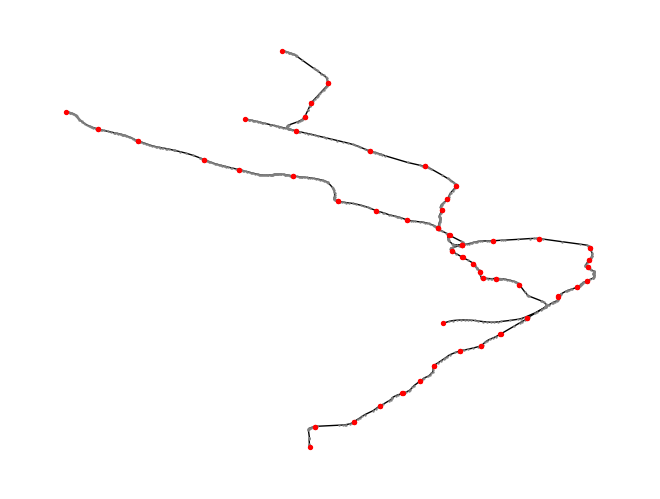

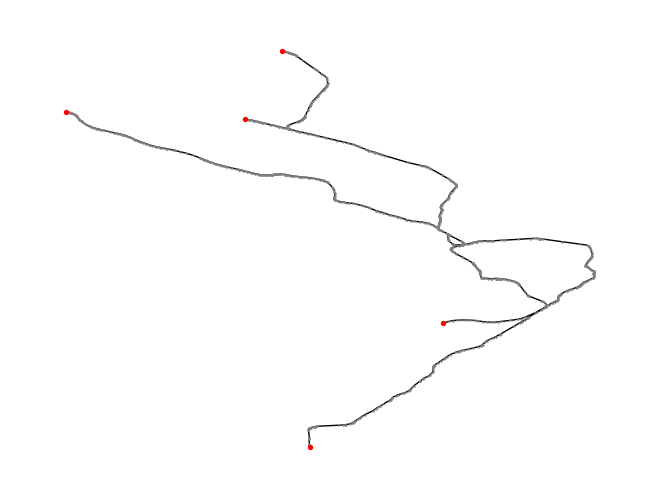

1
Central


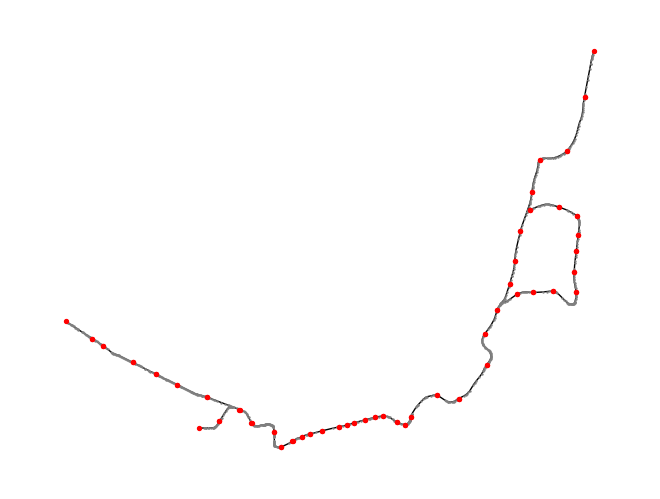

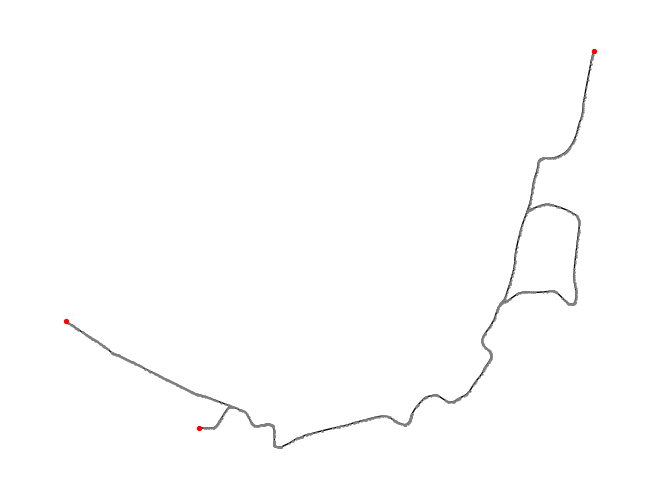

1
Metropolitan


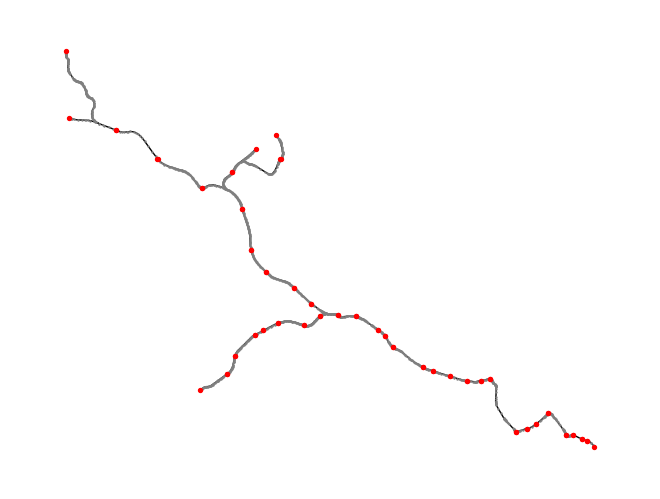

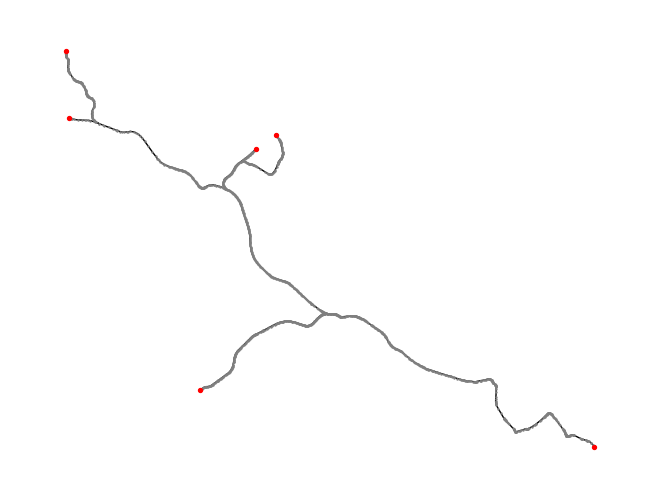

1
Circle


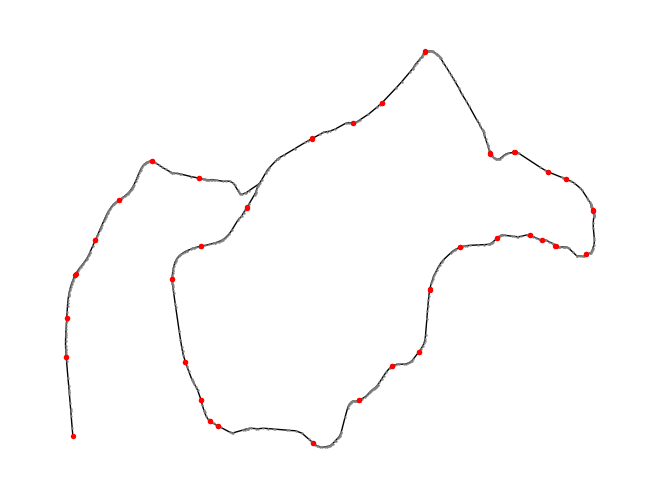

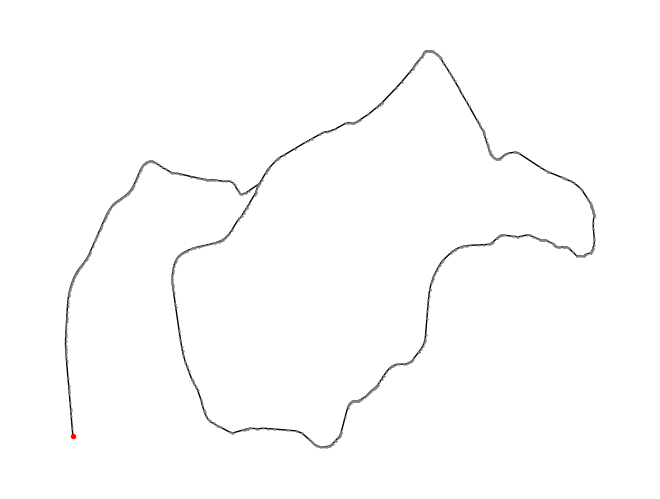

1
London Overground


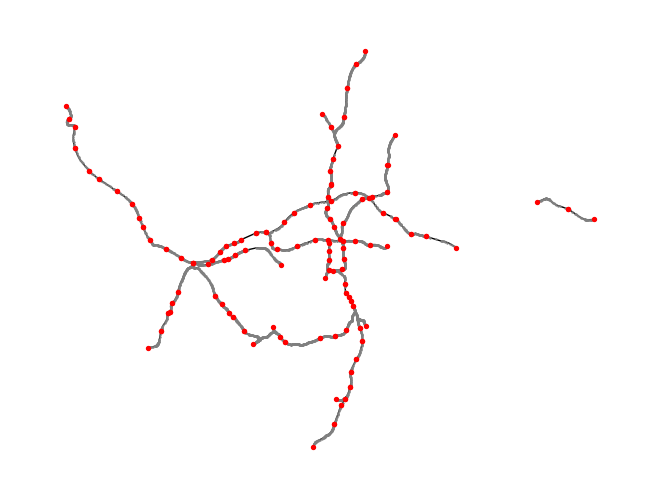

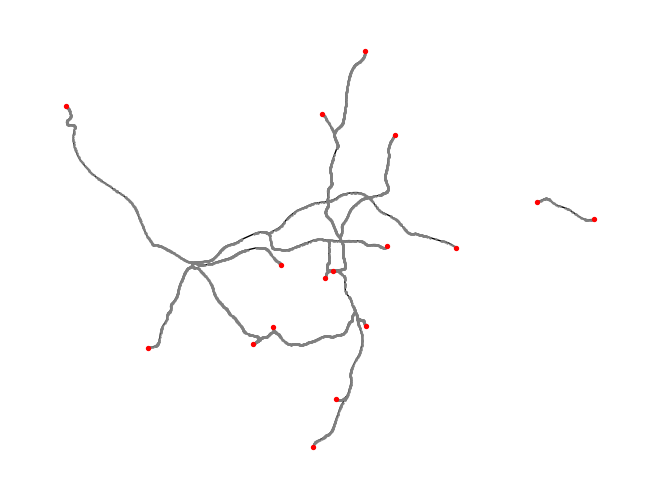

3
Victoria


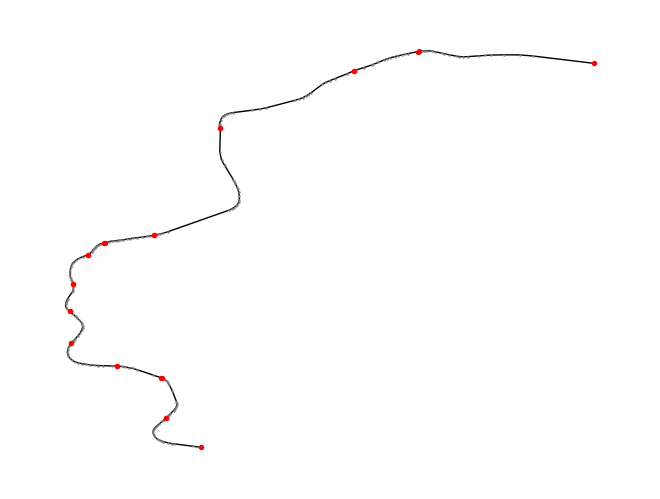

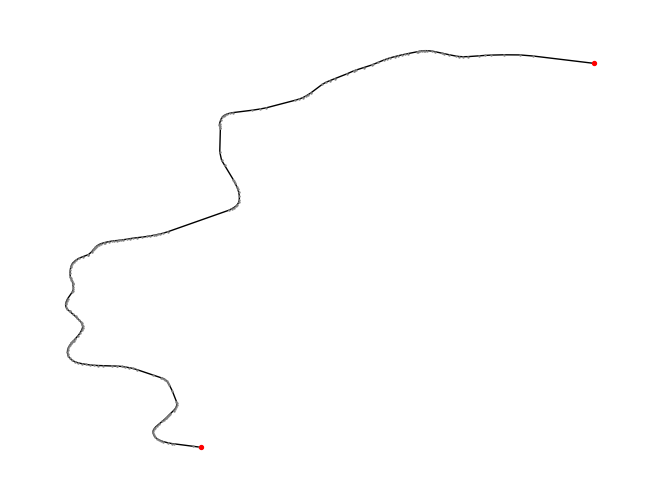

1
District


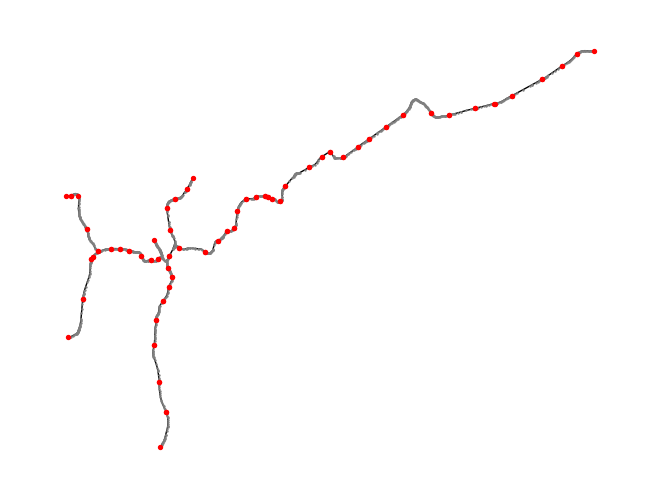

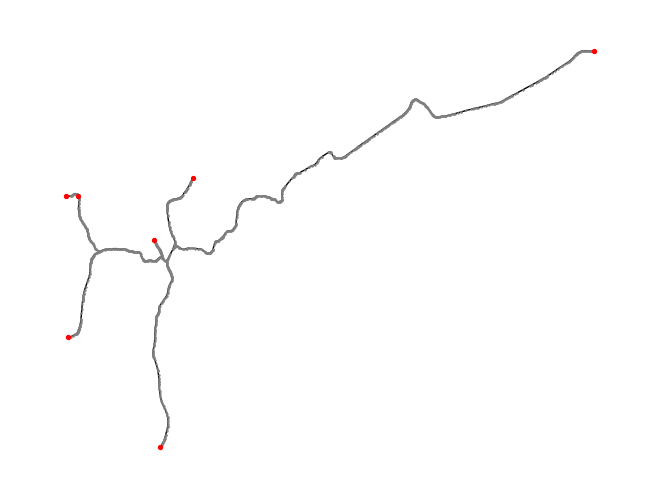

1
Hammersmith & City


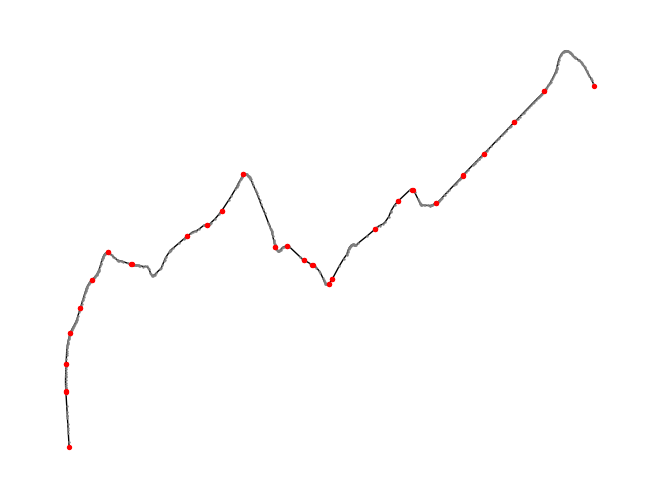

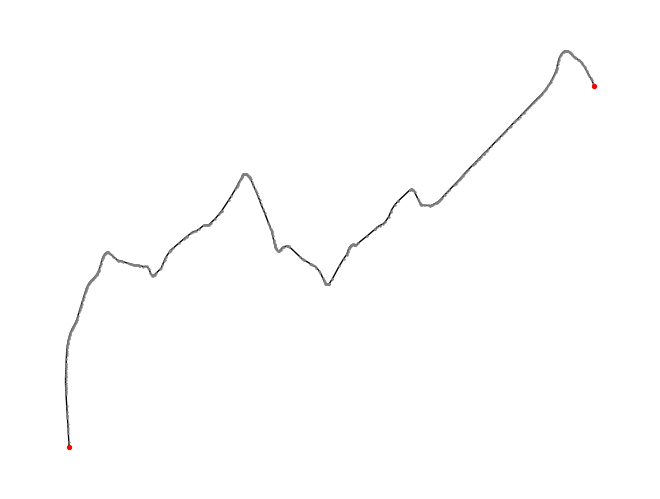

1
Bakerloo


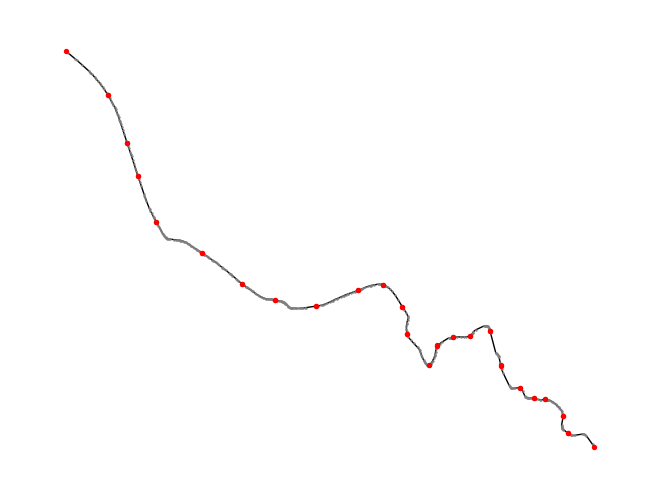

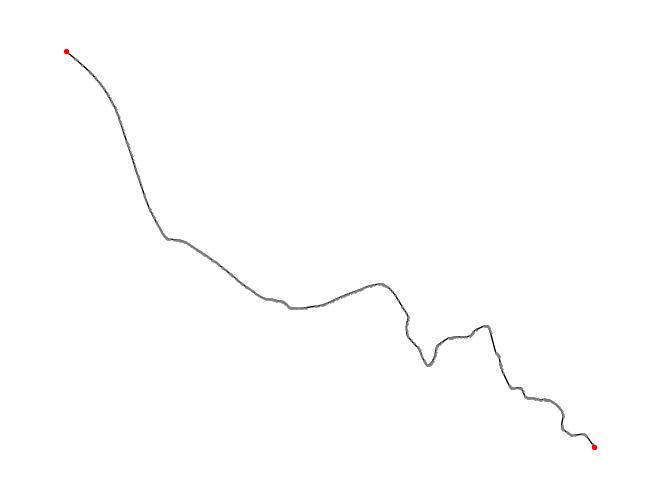

1
Waterloo & City


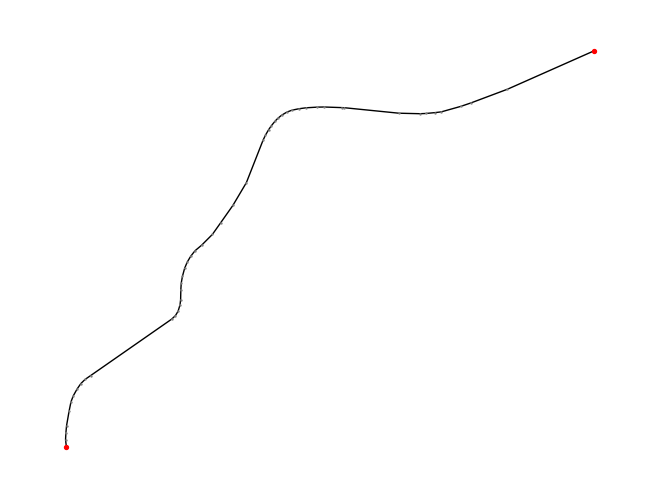

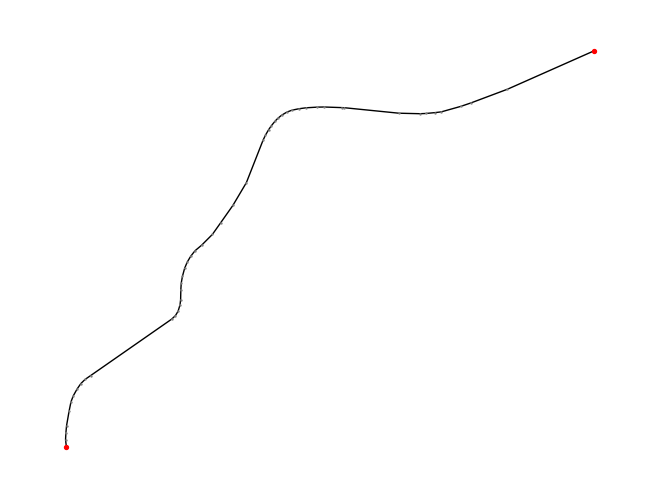

1
TfL Rail


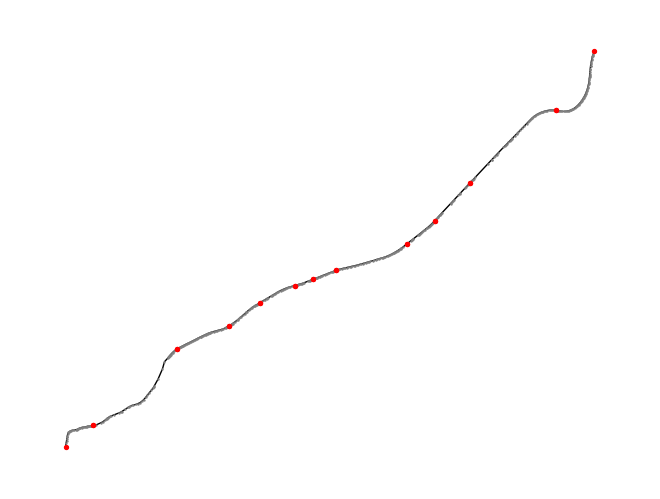

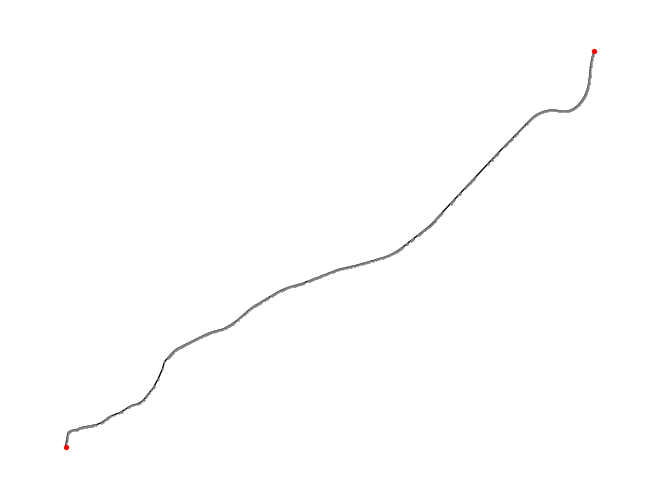

1
DLR


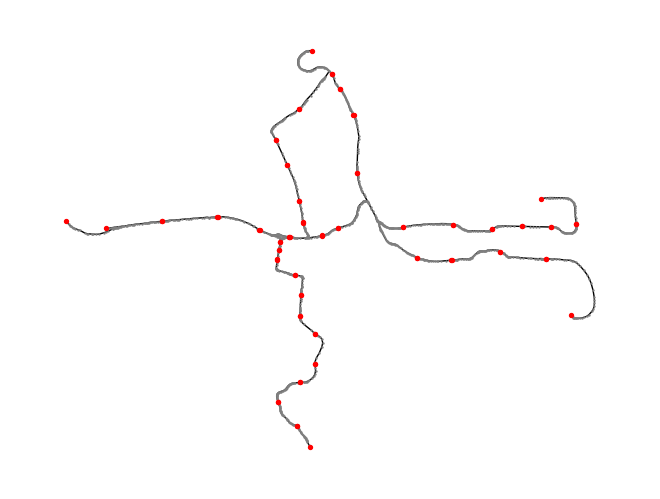

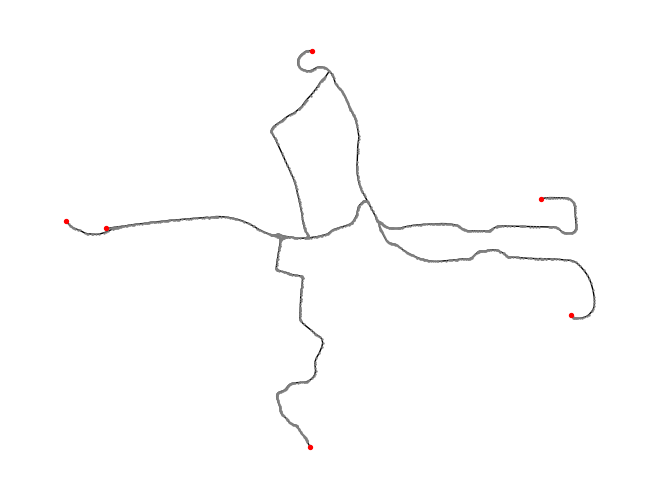

1
Jubilee


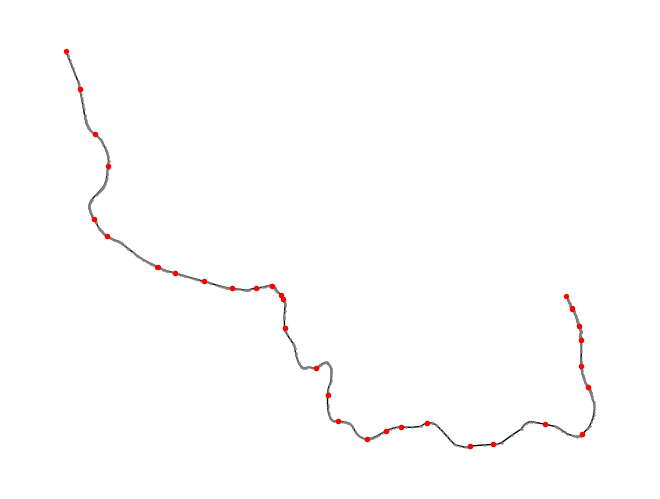

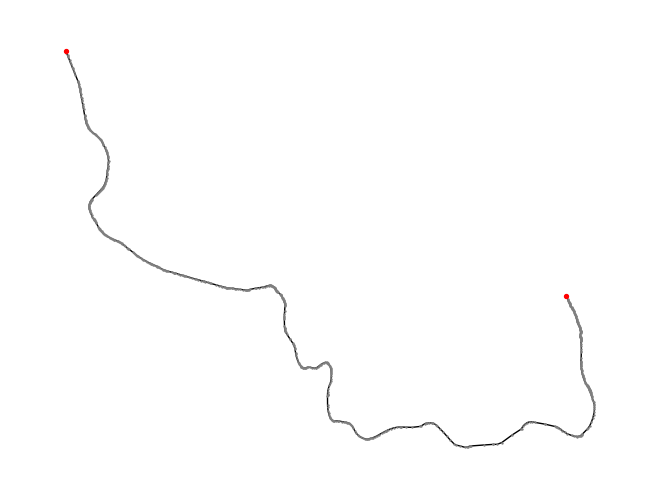

1
Piccadilly


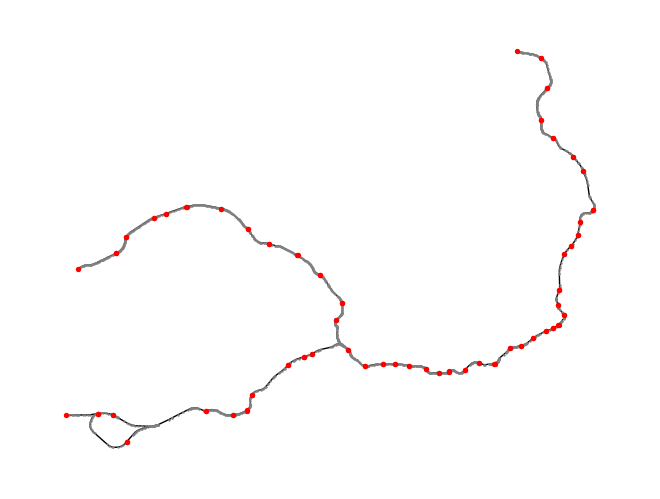

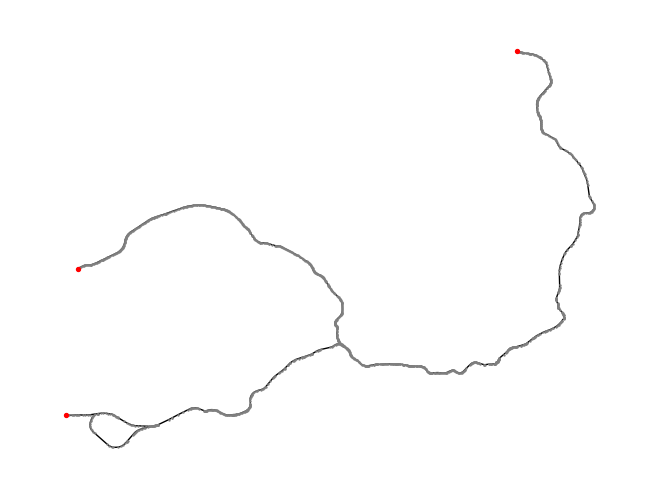

1


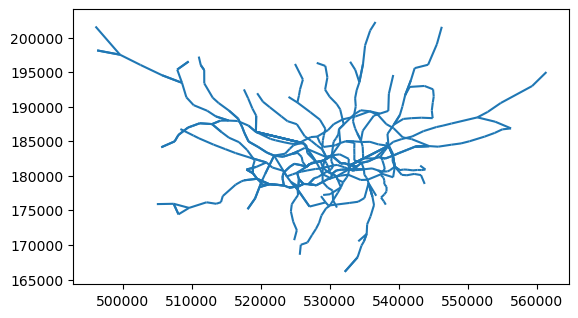

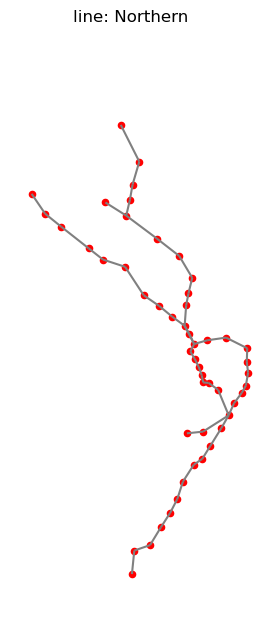

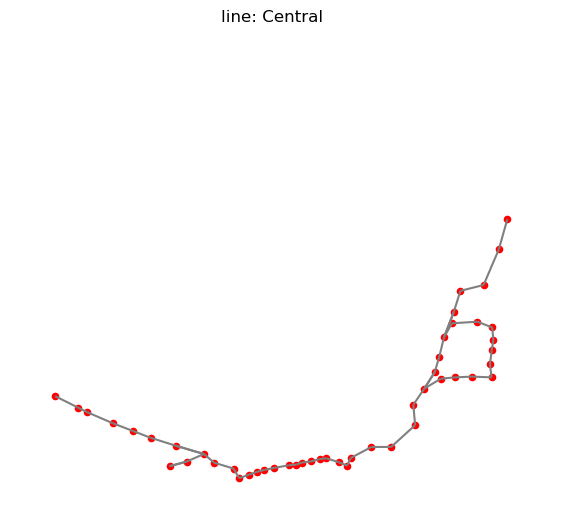

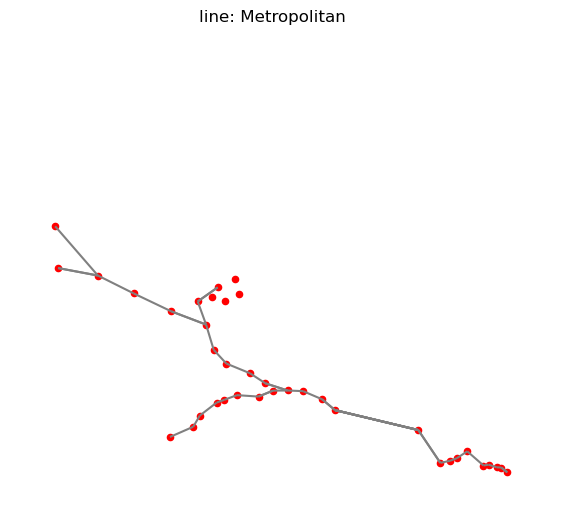

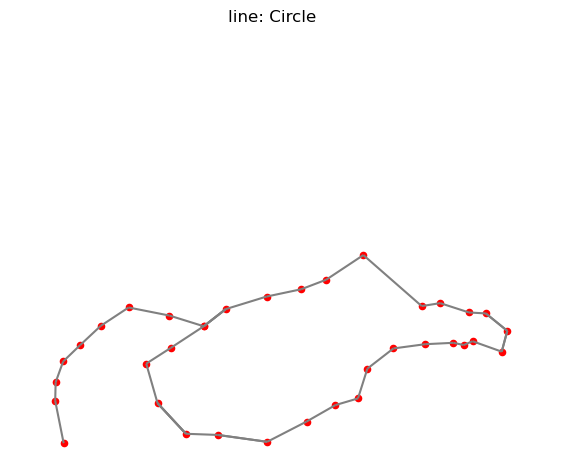

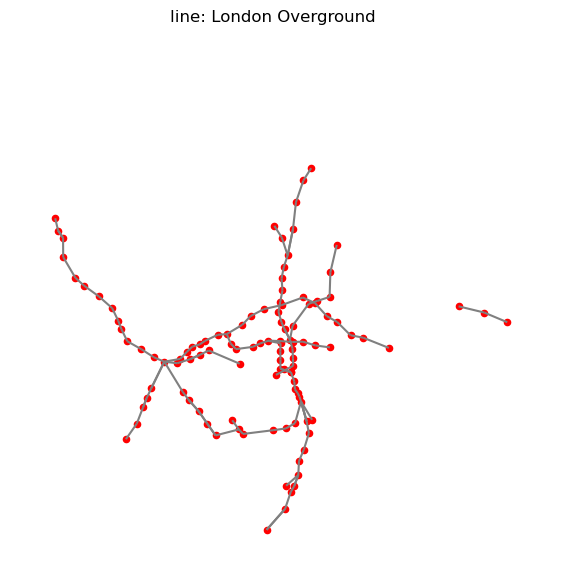

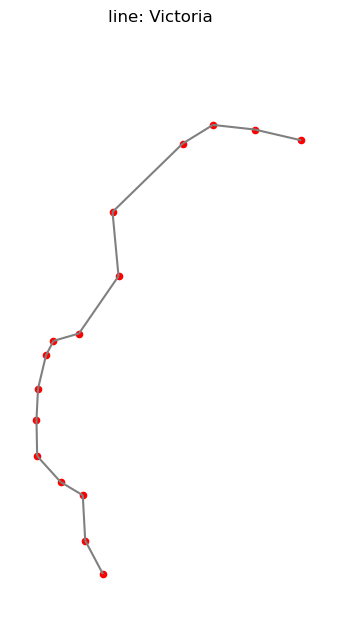

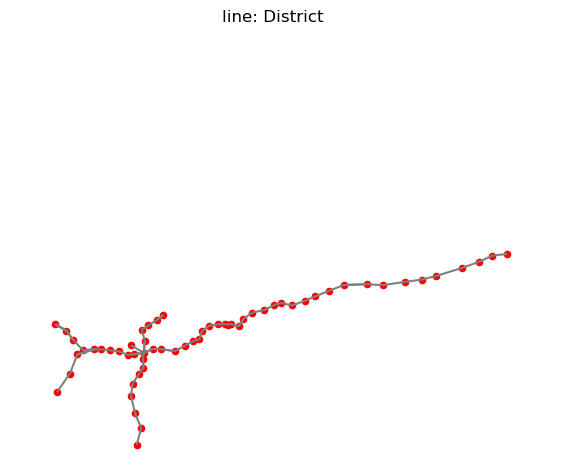

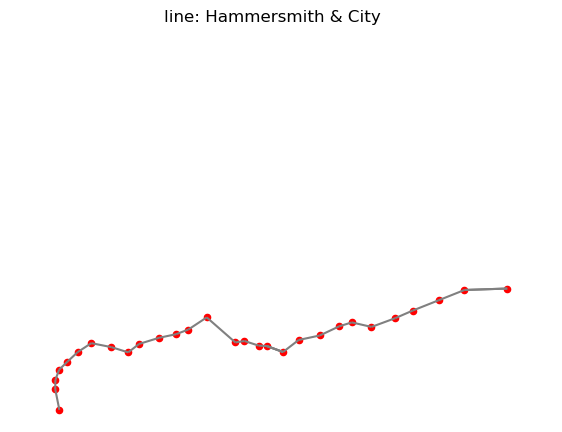

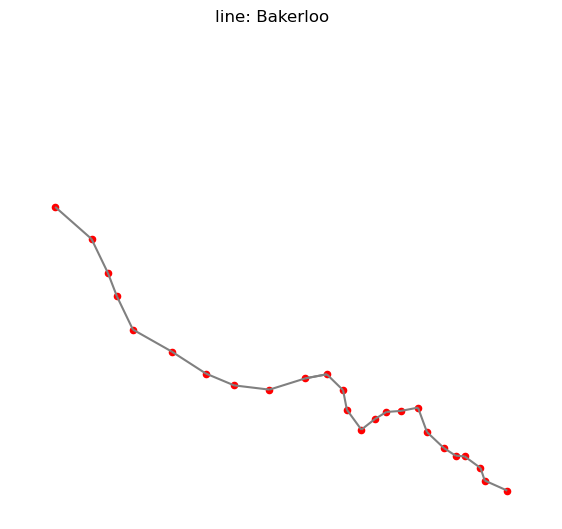

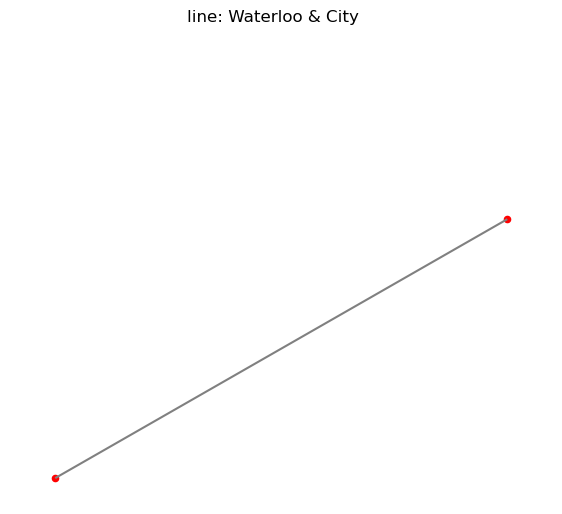

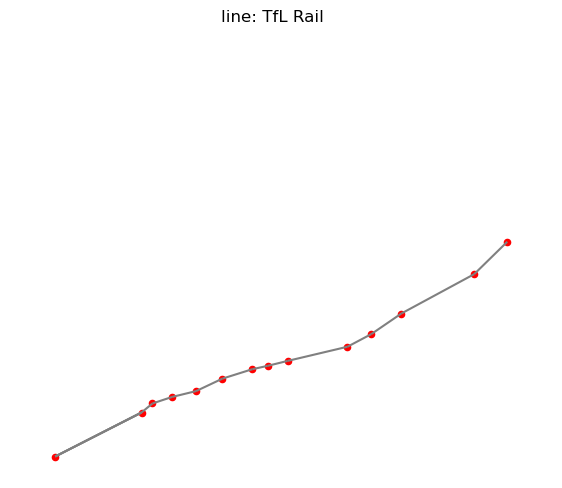

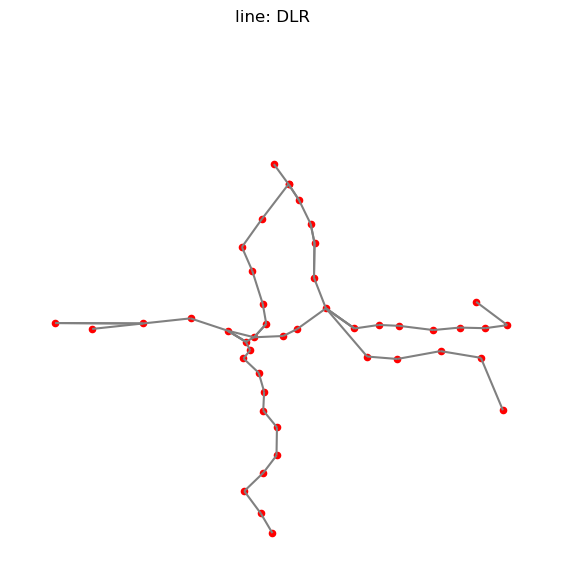

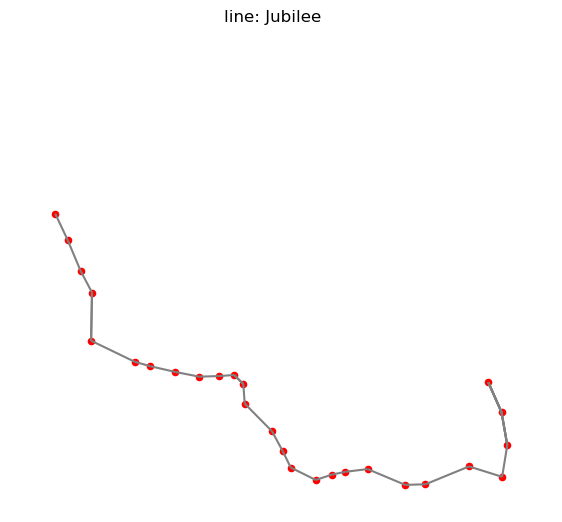

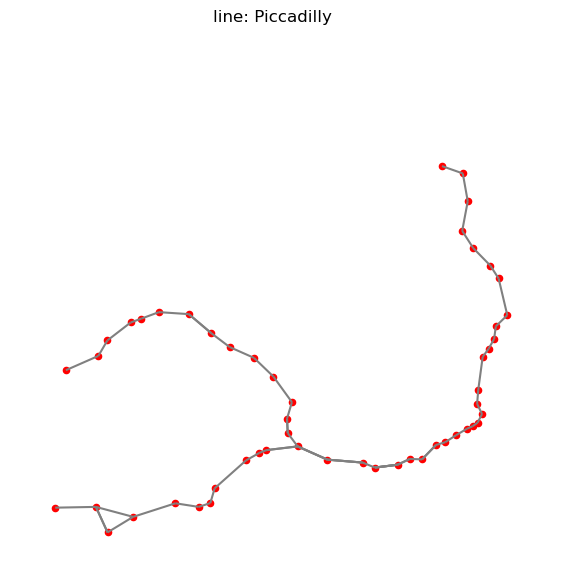

In [2]:
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)
    #set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction (except not really)
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

{'Circle', 'London Overground', 'Hammersmith & City', 'District', 'Northern', 'Bakerloo', 'Waterloo & City', 'DLR', 'Central', 'Jubilee', 'Metropolitan', 'TfL Rail', 'Victoria', 'Piccadilly'}


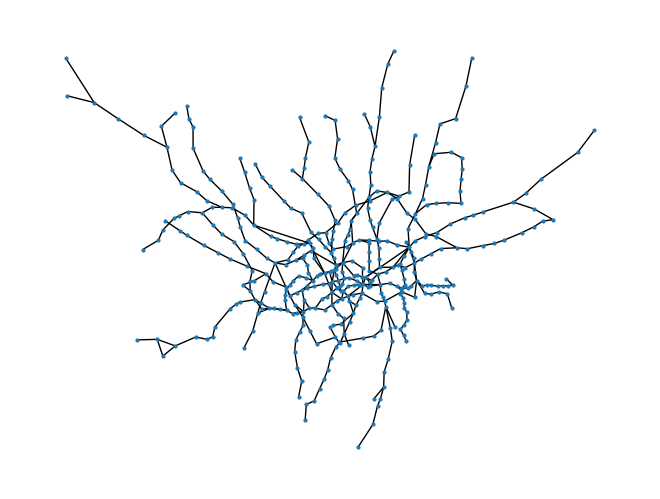

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
Liverpool Street,6
Green Park,6
Canning Town,6
Earl's Court,6
Oxford Circus,6
Waterloo,6


In [3]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()
#save position to graph
nx.set_node_attributes(G, pos, 'coords')
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])
#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(u,v) for  u,v in G.edges() if u == 'Baker Street' or v == 'Baker Street']
Baker_Street
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()
df.sort_values('degree', ascending =False).head(20)

1.1 Topological network拓扑网络

degree centrality

In [4]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')
#度中心性是通过节点的度（即直接连接到节点的边的数量）相对于可能的最大度（在无向图中为N-1，在有向图中为N-1入度和N-1出度，其中N是网络中的节点总数）来计算的。
#这行代码将计算出的度中心性值作为节点属性设置回图G中。dict(deg_london)确保度中心性数据以字典形式传递，其中节点作为键，度中心性值作为值。
#度中心性：
#定义：度中心性衡量节点与网络中其他节点的直接连接数。这是确定节点的直接影响的一种简单而有效的方法。
#背景：在地下网络中，具有高度中心性的车站有许多直达其他车站的路线，使其成为一个关键的换乘点。

In [5]:
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))
degree_sorted = df.sort_values(["degree"], ascending=False)
degree_sorted[0:15]

,station_name,degree
Stratford,NaN,0.0225
Bank and Monument,NaN,0.0200
Baker Street,NaN,0.0175
King's Cross St. Pancras,NaN,0.0175
Liverpool Street,NaN,0.0150
Green Park,NaN,0.0150
Canning Town,NaN,0.0150
Earl's Court,NaN,0.0150
Oxford Circus,NaN,0.0150
Waterloo,NaN,0.0150


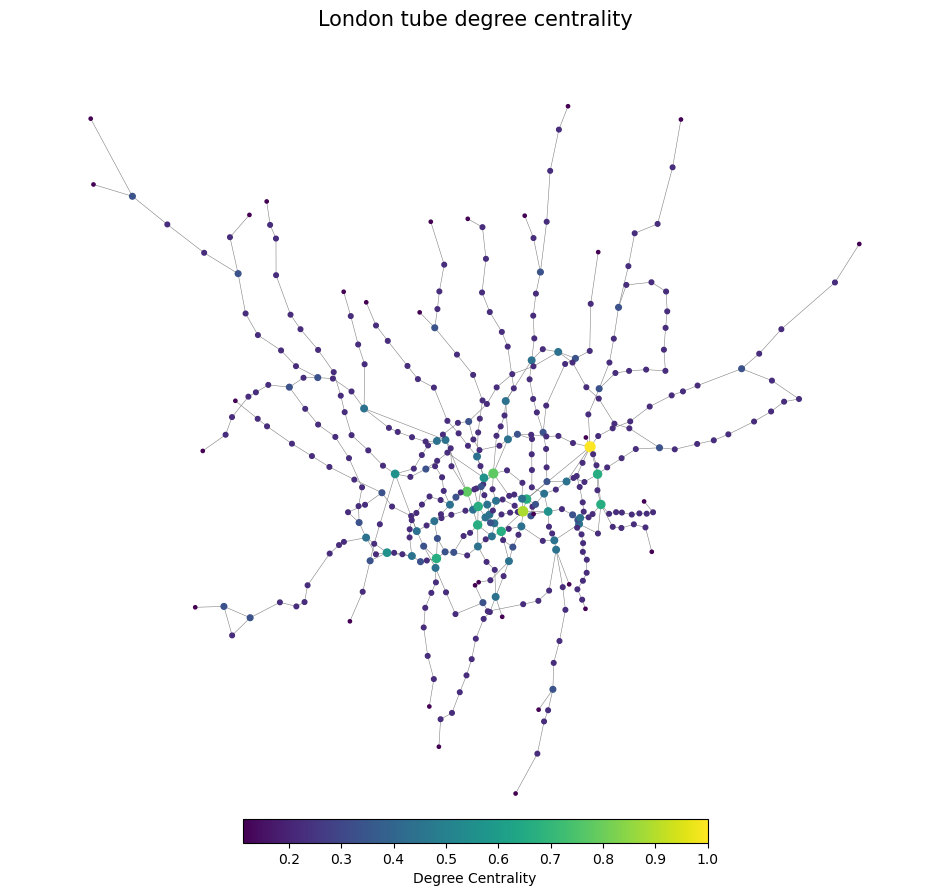

In [6]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]
deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]
# Plot graph
pos=pos
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)
plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5, pad=-0.05)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.savefig('figure/Figure 1. Spatial distribution of degree centrality at London Underground stations under topological networks.png')
plt.show()

betweenness centrality

In [7]:
#定义：中介中心性衡量一个节点位于其他节点之间的最短路径上的程度。它有助于识别在网络中充当网桥的节点。
#背景：地下网络中具有高中介中心的站点对于维持网络的连通性和效率至关重要。
#加权中介中心性考虑了在站点之间遍历路径的实际“成本”，这可能表示距离、时间甚至经济成本。这为车站在客流或出行效率方面的中心性提供了更现实的衡量标准。
#如果目标是从旅行时间或距离的角度来理解站点的重要性——也许是为了评估旅行效率或从物理距离的角度确定瓶颈——那么加权中介中心性将更合适。
#对于像伦敦地铁这样的交通网络，车站之间的穿越时间对乘客来说是一个重要因素，加权中间中心性通常为网络的弹性和效率提供了更实际的见解。它与乘客对网络的体验相一致，因此往往是此类应用的首选措施。
###  betweenness centrality:
#Let us compute the betweenness centrality for the network, considering the distance between stations:
#考虑到站点之间的距离，我们来计算网络的中心度：
bet_london_t=nx.betweenness_centrality(G, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')
# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))
df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,station_name,betweenness_t
Stratford,NaN,0.297846
Bank and Monument,NaN,0.290489
Liverpool Street,NaN,0.270807
King's Cross St. Pancras,NaN,0.255307
Waterloo,NaN,0.243921
Green Park,NaN,0.215835
Euston,NaN,0.208324
Westminster,NaN,0.203335
Baker Street,NaN,0.191568
Finchley Road,NaN,0.165085


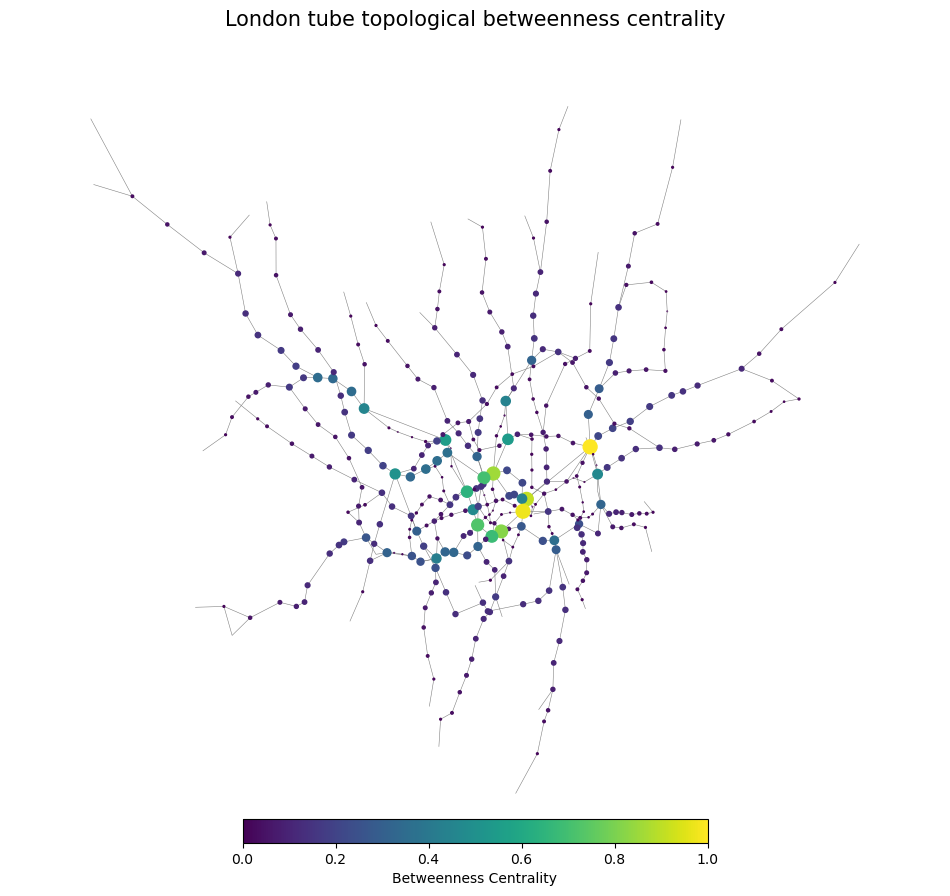

In [8]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]
#返回一个包含节点和其数据（属性）的迭代器，其中i[1]是节点数据的字典。
bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5, pad=-0.05)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.savefig('figure/Figure 2. Spatial distribution of betweenness centrality at London Underground stations under topological networks.png')
plt.show()

topological closeness centrality

In [9]:
#定义：紧密中心性衡量一个节点通过其最短路径到达网络中所有其他节点的速度。它表示节点传播或收集信息的相对速度。
#环境：在地下环境中，具有高度紧密中心性的车站可以有效地定位，以在整个网络中传播或收集乘客。
#突出显示位于最中心的车站，以最短的路径到达所有其他车站，表明它们在乘客分配方面的效率。
#topological closeness centrality
#拓扑接近中心性
clos_t=nx.closeness_centrality(G)
#因为没有指定distance参数，所以这里计算的是基于拓扑距离的接近中心性，即假设所有边的权重都相同（或者说所有边的长度都是1）。
#这意味着计算时仅考虑了边的数量，而没有考虑边的实际权重。
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')
# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))
df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]
#这行代码使用NetworkX的closeness_centrality函数计算图G中每个节点的加权接近中心性，其中distance='length'参数指定使用节点间边的'length'属性作为距离度量。
#接近中心性衡量了一个节点到所有其他节点的平均最短路径长度；较短的平均距离表示较高的中心性。

,station_name,closeness_t
Green Park,NaN,0.114778
Bank and Monument,NaN,0.113572
King's Cross St. Pancras,NaN,0.113443
Westminster,NaN,0.112549
Waterloo,NaN,0.112265
Oxford Circus,NaN,0.111204
Bond Street,NaN,0.110988
Angel,NaN,0.110742
Farringdon,NaN,0.110742
Moorgate,NaN,0.110314


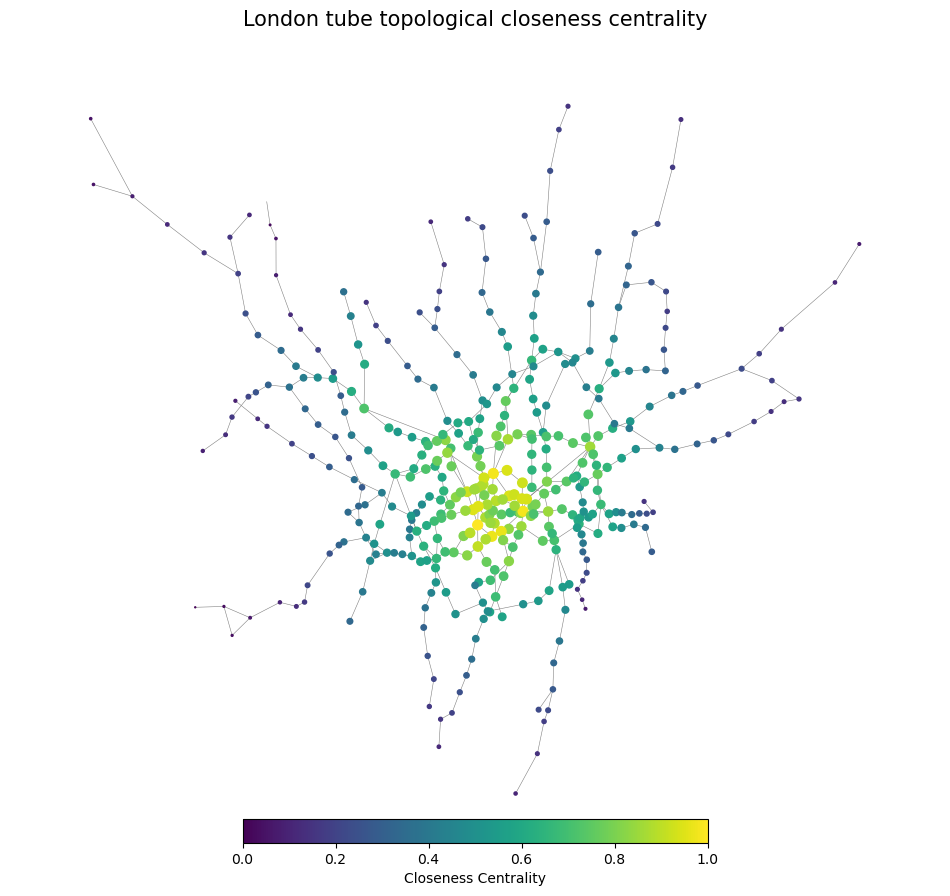

In [10]:
# Lets set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]
closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5, pad=-0.05)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.savefig('figure/Figure 3. Spatial distribution of Closeness centrality at London Underground stations under topological networks.png')
plt.show()

1.2 Introduction to the Impact Measures Formula1.2 影响措施公式介绍

1.3 Computing centre metrics1.3 计算中心度量

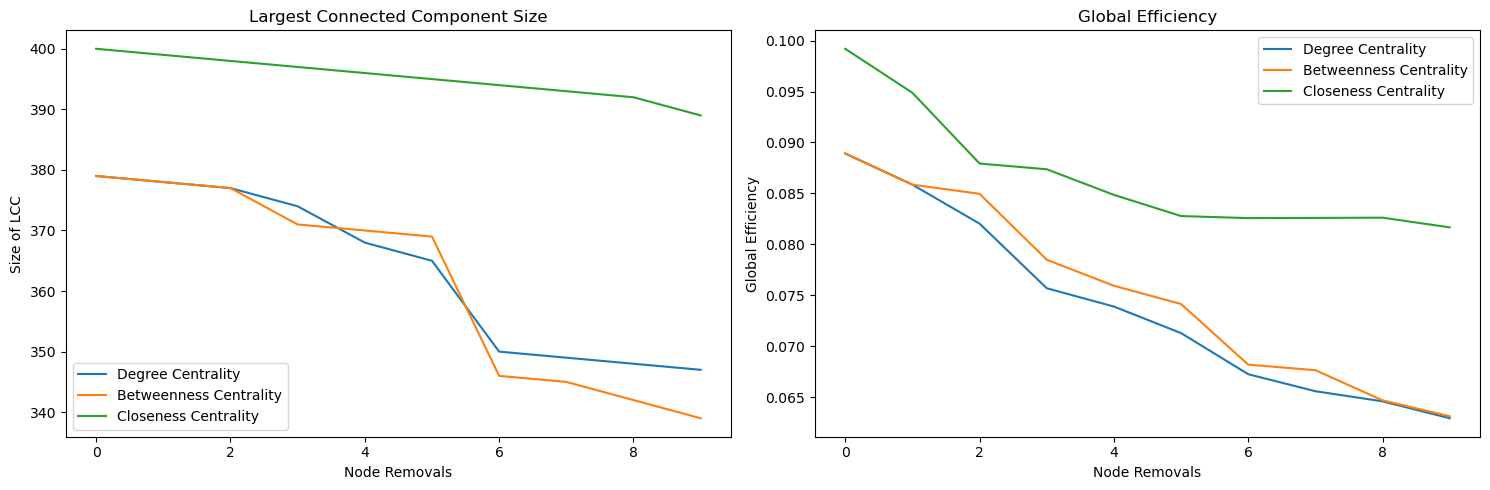

In [11]:
#1.3 A
# Calculate centrality measures计算中心度量
deg_centrality = nx.degree_centrality(G)
bet_centrality_t = nx.betweenness_centrality(G, normalized=False)
clos_centrality_t = nx.closeness_centrality(G)
# Sort nodes by centrality measures and select top 10按中心度排序节点，选出前 10 个节点
top_deg = sorted(deg_centrality, key=deg_centrality.get, reverse=True)[:10]
top_bet_t = sorted(bet_centrality_t, key=bet_centrality_t.get, reverse=True)[:10]
top_clos_t = sorted(clos_centrality_t, key=clos_centrality_t.get, reverse=True)[:10]
#此函数给定一个图形和一个 的列表，将从图形中逐个删除每个节点，然后计算最大连接组件 （LCC） 的大小和每次删除后的全局效率。
def evaluate_removal(G, nodes):
    largest_cc_sizes = [] #初始化以在每个节点删除后存储 LCC 大小和全局效率
    global_efficiencies = []
    for node in nodes:
        # Remove the node and calculate the metrics
        G.remove_node(node) #从图形中删除指定的节点
        largest_cc_sizes.append(len(max(nx.connected_components(G), key=len)))
        global_efficiencies.append(nx.global_efficiency(G)) #然后计算最大连接组件尺寸和全局效率，并将其附加到各自的列表中。
    return largest_cc_sizes, global_efficiencies #初始化字典以保存不同中心性度量的节点删除影响的结果。
# Dictionary to hold the results保存结果的字典
results = {}
# Evaluate removal for each centrality measure评估每种中心度量的移除情况
for label, nodes in [('Degree Centrality', top_deg),  #此循环遍历每个中心性度量，创建原始图形的副本，并调用以获取 LCC 大小和效率，并将它们存储在字典中。
                     ('Betweenness Centrality', top_bet_t), 
                     ('Closeness Centrality', top_clos_t)]:
    G_copy = G.copy()
    lcc, eff = evaluate_removal(G_copy, nodes)
    results[label] = {'LCC': lcc, 'Efficiency': eff}
# Plotting the results绘制结果图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for label, data in results.items():
    ax1.plot(data['LCC'], label=label)
    ax2.plot(data['Efficiency'], label=label)
ax1.set_title('Largest Connected Component Size')
ax1.set_xlabel('Node Removals')
ax1.set_ylabel('Size of LCC')
ax1.legend()
ax2.set_title('Global Efficiency')
ax2.set_xlabel('Node Removals')
ax2.set_ylabel('Global Efficiency')
ax2.legend()
plt.tight_layout()
plt.show()

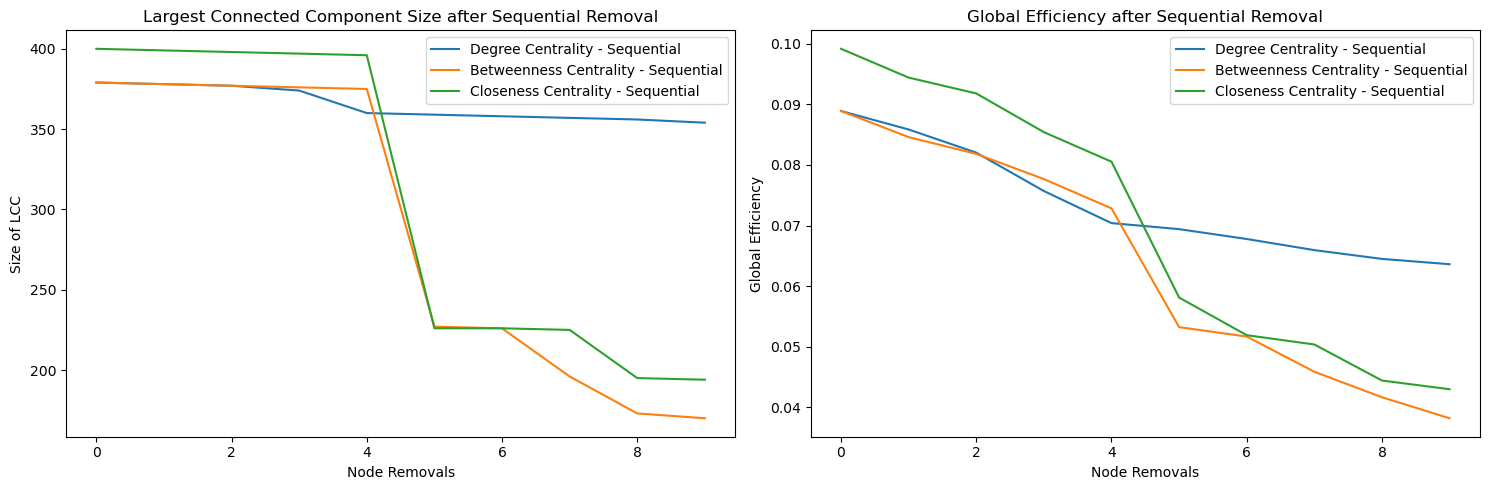

In [12]:
#1.3 B
# Define a function to handle sequential removal and evaluation
def sequential_removal_and_evaluation(G, centrality_func, weight=None):#定义一个函数，用于处理基于给定中心性度量的节点的顺序删除。该函数采用一个图、一个中心性函数和一个可选参数
    largest_cc_sizes = [] #初始化两个空列表，以存储最大连接组件 （LCC） 的大小以及每个节点删除后的全局效率。
    global_efficiencies = []
    G_temp = G.copy()        #创建要处理的原始图形的临时副本，保留原始图形以供以后使用。
    for _ in range(10): #启动一个循环，根据当前中心性度量删除前 10 个节点。每次通过循环都会删除一个节点并重新计算指标。
        # Recalculate centrality each time after node removal
        if weight: #检查是否提供了权重参数，并使用权重参数调用中心性函数（如果是），每次删除节点后重新计算中心性。
            centrality = centrality_func(G_temp, weight=weight)
        else:
            centrality = centrality_func(G_temp)
        # Remove the highest-ranked node确定接下来要删除的当前图形状态中中心性得分最高的节点。
        highest_ranked_node = max(centrality, key=centrality.get)
        G_temp.remove_node(highest_ranked_node)#从临时图中删除排名最高的节点。
        # Calculate and store the size of the largest connected component and global efficiency
        largest_cc_sizes.append(len(max(nx.connected_components(G_temp), key=len)))#计算修改后的图形中最大连接组件的大小，并将其追加到列表中。
        global_efficiencies.append(nx.global_efficiency(G_temp)) #计算修改后的图形的全局效率并将其追加到列表中。
    return largest_cc_sizes, global_efficiencies
# Dictionary to hold the results for sequential removal
sequential_results = {} #初始化一个空字典，以存储每个中心性度量的顺序删除结果。
# Evaluate sequential removal for each centrality measure评估每种中心度量的顺序移除
centrality_measures = {
    'Degree Centrality': nx.degree_centrality,
    'Betweenness Centrality': lambda G: nx.betweenness_centrality(G, normalized=False),
    'Closeness Centrality': lambda G: nx.closeness_centrality(G)
}
# Now iterate over the centrality measures and call each function without passing the 'weight' externally遍历定义的中心性度量值，调用每个度量值，并将结果存储在字典中。
for label, func in centrality_measures.items():
    lcc, eff = sequential_removal_and_evaluation(G, func)
    sequential_results[label] = {'LCC': lcc, 'Efficiency': eff}
# Plotting the results of sequential removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for label, data in sequential_results.items():
    ax1.plot(data['LCC'], label=f'{label} - Sequential')
    ax2.plot(data['Efficiency'], label=f'{label} - Sequential')
ax1.set_title('Largest Connected Component Size after Sequential Removal')
ax1.set_xlabel('Node Removals')
ax1.set_ylabel('Size of LCC')
ax1.legend()
ax2.set_title('Global Efficiency after Sequential Removal')
ax2.set_xlabel('Node Removals')
ax2.set_ylabel('Global Efficiency')
ax2.legend()
plt.tight_layout()
plt.show()

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph here for testing
# As the graph 'G' is not defined in this environment, we assume it is a predefined graph.
# G = nx.some_network()

# Calculate centrality measures
deg_centrality = nx.degree_centrality(G)
bet_centrality = nx.betweenness_centrality(G, normalized=False)
clos_centrality = nx.closeness_centrality(G)

# Sort nodes by centrality measures and select top 10
top_deg = sorted(deg_centrality, key=deg_centrality.get, reverse=True)[:10]
top_bet = sorted(bet_centrality, key=bet_centrality.get, reverse=True)[:10]
top_clos = sorted(clos_centrality, key=clos_centrality.get, reverse=True)[:10]

# Define the evaluation function
def evaluate_removal(G, nodes):
    largest_cc_sizes = []  # Store LCC sizes after each node removal
    global_efficiencies = []  # Store global efficiency after each node removal
    for node in nodes:
        # Remove the node and calculate the metrics
        G.remove_node(node)
        largest_cc_sizes.append(len(max(nx.connected_components(G), key=len)))
        global_efficiencies.append(nx.global_efficiency(G))
    return largest_cc_sizes, global_efficiencies

# Initialize dictionaries to save the results of different centrality measure removal impacts
non_sequential_results = {}
sequential_results = {}

# Evaluate non-sequential removal for each centrality measure
for label, nodes in [('Degree Centrality', top_deg),
                     ('Betweenness Centrality', top_bet),
                     ('Closeness Centrality', top_clos)]:
    G_copy = G.copy()
    lcc_sizes, global_effs = evaluate_removal(G_copy, nodes)
    non_sequential_results[label] = {'Nodes': nodes, 'LCC': lcc_sizes, 'Efficiency': global_effs}

# Evaluate sequential removal for each centrality measure
for label, centrality_func in [('Degree Centrality', nx.degree_centrality),
                               ('Betweenness Centrality', nx.betweenness_centrality),
                               ('Closeness Centrality', nx.closeness_centrality)]:
    G_copy = G.copy()
    lcc_sizes_seq = []
    global_effs_seq = []
    nodes_removed_seq = []
    for _ in range(10):
        # Recalculate centrality each time after node removal
        centrality = centrality_func(G_copy)
        # Remove the highest-ranked node
        highest_ranked_node = max(centrality, key=centrality.get)
        nodes_removed_seq.append(highest_ranked_node)
        G_copy.remove_node(highest_ranked_node)
        # Calculate and store the size of the largest connected component and global efficiency
        lcc_sizes_seq.append(len(max(nx.connected_components(G_copy), key=len)))
        global_effs_seq.append(nx.global_efficiency(G_copy))
    sequential_results[label] = {'Nodes': nodes_removed_seq, 'LCC': lcc_sizes_seq, 'Efficiency': global_effs_seq}

# Print the results
for label, data in non_sequential_results.items():
    print(f"{label} - Non-Sequential:")
    formatted_efficiencies = ['{:.4f}'.format(eff) for eff in data['Efficiency']]
    print("Nodes removed:", data['Nodes'])
    print("LCC sizes:", data['LCC'])
    print("Global efficiencies:", formatted_efficiencies)
    print()

for label, data in sequential_results.items():
    print(f"{label} - Sequential:")
    formatted_efficiencies = ['{:.4f}'.format(eff) for eff in data['Efficiency']]
    print("Nodes removed:", data['Nodes'])
    print("LCC sizes:", data['LCC'])
    print("Global efficiencies:", formatted_efficiencies)
    print()


Degree Centrality - Non-Sequential:
Nodes removed: ['Stratford', 'Bank and Monument', 'Baker Street', "King's Cross St. Pancras", 'Liverpool Street', 'West Ham', 'Canning Town', 'Waterloo', 'Green Park', "Earl's Court"]
LCC sizes: [379, 378, 377, 374, 368, 365, 350, 349, 348, 347]
Global efficiencies: ['0.0889', '0.0859', '0.0820', '0.0757', '0.0739', '0.0713', '0.0673', '0.0656', '0.0646', '0.0629']

Betweenness Centrality - Non-Sequential:
Nodes removed: ['Stratford', 'Bank and Monument', 'Liverpool Street', "King's Cross St. Pancras", 'Waterloo', 'Green Park', 'Euston', 'Westminster', 'Baker Street', 'Finchley Road']
LCC sizes: [379, 378, 377, 371, 370, 369, 346, 345, 342, 339]
Global efficiencies: ['0.0889', '0.0859', '0.0850', '0.0785', '0.0759', '0.0742', '0.0682', '0.0677', '0.0647', '0.0631']

Closeness Centrality - Non-Sequential:
Nodes removed: ['Green Park', 'Bank and Monument', "King's Cross St. Pancras", 'Westminster', 'Waterloo', 'Oxford Circus', 'Bond Street', 'Farringdo

In [14]:
# Data for Betweenness Centrality - Non-Sequential
non_seq_data = {
    'Nodes removed': ['Stratford', 'Bank and Monument', 'Liverpool Street', 
                      "King's Cross St. Pancras", 'Waterloo', 'Green Park', 
                      'Euston', 'Westminster', 'Baker Street', 'Finchley Road'],
    'LCC sizes': [379, 378, 377, 371, 370, 369, 346, 345, 342, 339],
    'Global efficiencies': ['0.0889', '0.0859', '0.0850', '0.0785', '0.0759', 
                            '0.0742', '0.0682', '0.0677', '0.0647', '0.0631']
}

# Data for Betweenness Centrality - Sequential
seq_data = {
    'Nodes removed': ['Stratford', "King's Cross St. Pancras", 'Waterloo', 
                      'Bank and Monument', 'Canada Water', 'West Hampstead', 
                      "Earl's Court", "Shepherd's Bush", 'Euston', 'Baker Street'],
    'LCC sizes': [379, 378, 377, 376, 375, 227, 226, 196, 173, 170],
    'Global efficiencies': ['0.0889', '0.0846', '0.0818', '0.0777', '0.0728', 
                            '0.0532', '0.0517', '0.0458', '0.0416', '0.0382']
}

# Creating dataframes
df_non_seq = pd.DataFrame(non_seq_data)
df_seq = pd.DataFrame(seq_data)

# Output the tables as string (this will not display as tables in the Python interpreter directly, 
# but can be used to create text-based tables in a console or a GUI application)
non_seq_table = df_non_seq.to_string(index=False)
seq_table = df_seq.to_string(index=False)

# Print the tables
print("Betweenness Centrality - Non-Sequential:")
print(non_seq_table)
print("\nBetweenness Centrality - Sequential:")
print(seq_table)


Betweenness Centrality - Non-Sequential:
           Nodes removed  LCC sizes Global efficiencies
               Stratford        379              0.0889
       Bank and Monument        378              0.0859
        Liverpool Street        377              0.0850
King's Cross St. Pancras        371              0.0785
                Waterloo        370              0.0759
              Green Park        369              0.0742
                  Euston        346              0.0682
             Westminster        345              0.0677
            Baker Street        342              0.0647
           Finchley Road        339              0.0631

Betweenness Centrality - Sequential:
           Nodes removed  LCC sizes Global efficiencies
               Stratford        379              0.0889
King's Cross St. Pancras        378              0.0846
                Waterloo        377              0.0818
       Bank and Monument        376              0.0777
            Canada Water 

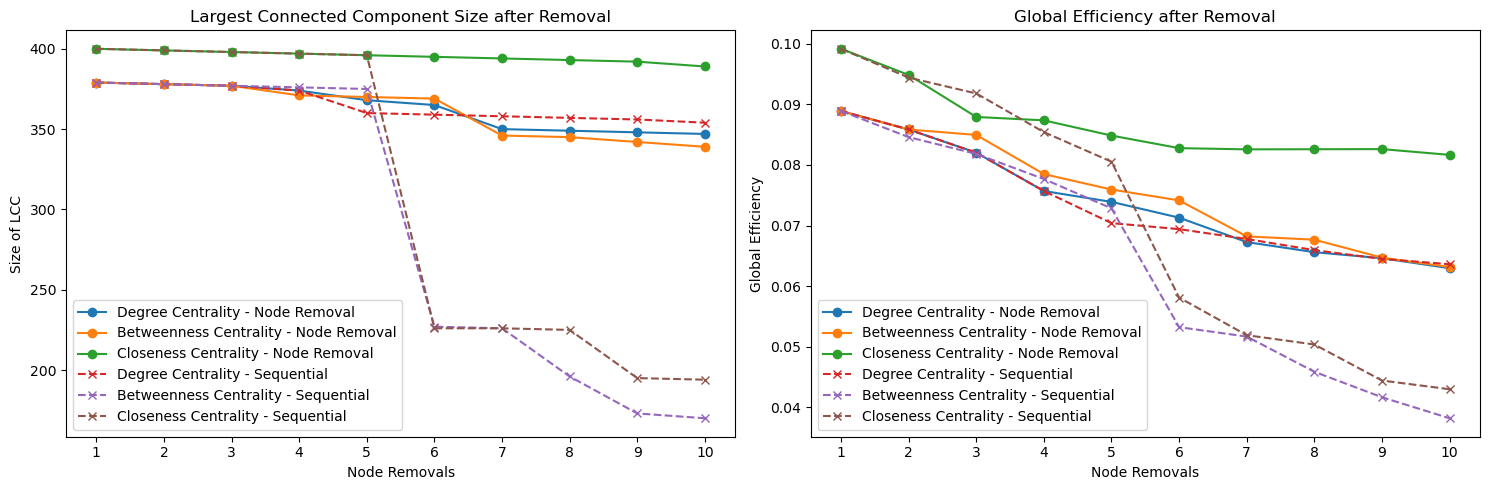

In [16]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Assuming 'results' and 'sequential_results' are dictionaries containing the LCC sizes and Efficiency values
# for Node Removal and Sequential strategies.

# Plot results from the first strategy (Node Removals)
for label, data in results.items():
    ax1.plot(range(1, len(data['LCC']) + 1), data['LCC'], marker='o', label=f'{label} - Node Removal')
    ax2.plot(range(1, len(data['Efficiency']) + 1), data['Efficiency'], marker='o', label=f'{label} - Node Removal')

# Plot results from the second strategy (Sequential Removal)
for label, data in sequential_results.items():
    ax1.plot(range(1, len(data['LCC']) + 1), data['LCC'], linestyle='--', marker='x', label=f'{label} - Sequential')
    ax2.plot(range(1, len(data['Efficiency']) + 1), data['Efficiency'], linestyle='--', marker='x', label=f'{label} - Sequential')

# Set titles and labels for the first subplot
ax1.set_title('Largest Connected Component Size after Removal')
ax1.set_xlabel('Node Removals')
ax1.set_ylabel('Size of LCC')
ax1.set_xticks(range(1, 11))  # Set x-ticks to show 1-10
ax1.legend()

# Set titles and labels for the second subplot
ax2.set_title('Global Efficiency after Removal')
ax2.set_xlabel('Node Removals')
ax2.set_ylabel('Global Efficiency')
ax2.set_xticks(range(1, 11))  # Set x-ticks to show 1-10
ax2.legend()

# Adjust layout for better visibility
plt.tight_layout()
plt.savefig('figure/Figure 4. Metric changes after removing centrality sorted nodes in sequential and non-sequential order.png')
plt.show()

2. Weighted network Add flows - practical10 2. 加权网络 添加flows——practical10

In [6]:
london_OD = pd.read_csv('london_flows.csv')
london_OD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [7]:
london_OD.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [8]:
#check that our OD data and network data match
OD_names = set(london_OD.station_origin.unique())
network_names = set([n for n in G.nodes()])
# is there any difference
network_names.symmetric_difference(OD_names)

{'Battersea Power Station', 'Nine Elms'}

In [9]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Nine Elms', 'Battersea Power Station']

In [11]:
london_OD_new = london_OD[~london_OD.station_origin.isin(_filter)]
london_OD_new = london_OD[~london_OD.station_destination.isin(_filter)]
london_OD_new

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [12]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [13]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_new.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [14]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

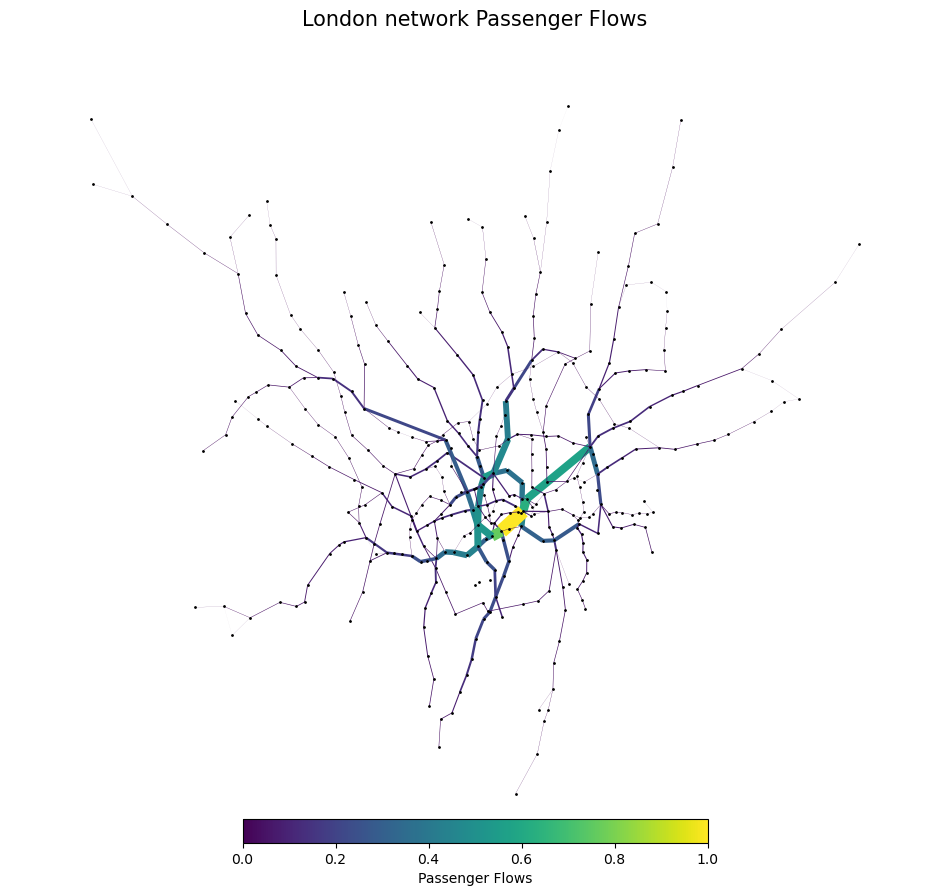

In [15]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]
# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)
nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)
plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5,pad=-0.05)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.savefig('figure/Figure 5. London Underground Flow Map.png')
plt.show()

In [16]:
#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])
nx.write_graphml_lxml(G, "london_updated.graph")

In [17]:
#Create OD pairs with distance, population and jobs
#### Create Origin Destination matrix
OD = pd.pivot_table(london_OD_new, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.to_csv('OD_matrix.csv')

/tmp/ipykernel_27671/1875592092.py:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  OD = pd.pivot_table(london_OD_new,
/tmp/ipykernel_27671/1875592092.py:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  OD = pd.pivot_table(london_OD_new,
/tmp/ipykernel_27671/1875592092.py:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  OD = pd.pivot_table(london_OD_new,


In [18]:
OD.sort_values(by='All').tail(10)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Finsbury Park,0,0,19,156,39,0,6,1,0,34,...,16,4,113,18,0,0,0,2,0,24735
Canada Water,0,0,17,0,0,0,5,0,43,81,...,0,1,6,2,0,3,0,4,0,27026
King's Cross St. Pancras,0,0,22,842,160,0,7,2,0,135,...,38,8,71,214,0,3,0,12,0,28307
Bank and Monument,0,0,6,31,250,25,0,0,0,518,...,38,2,31,1,0,10,0,9,509,29494
Liverpool Street,0,0,12,384,150,0,3,3,0,121,...,5,1,15,53,61,12,0,1,0,31473
London Bridge,0,0,24,20,47,0,9,1,0,905,...,0,1,52,1,0,5,0,9,0,32597
Victoria,0,0,30,59,153,0,9,2,0,235,...,53,2,122,2,0,7,0,26,0,37517
Stratford,223,25,7,18,186,157,3,0,0,167,...,3,4,43,1,0,133,0,8,1106,59311
Waterloo,0,0,14,108,381,0,6,1,0,306,...,2,0,43,5,0,12,0,18,0,67372


In [19]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()
df.sort_values('degree', ascending =False).head(20)

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
Liverpool Street,6
Green Park,6
Canning Town,6
Earl's Court,6
Oxford Circus,6
Waterloo,6


In [20]:
#lets get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

II.1. Centrality Measures for weighted network

In [21]:
#删除flow为0的边Remove edges with a flow of 0
edges_to_remove = [(e1, e2) for e1, e2, flows in G.edges(data='flows') if flows == 0]
edges_to_remove

[('Kennington', 'Nine Elms'),
 ('Battersea Power Station', 'Nine Elms'),
 ('Wandsworth Road', 'Battersea Park')]

Data for Battersea Power Station and Nine Elms Station does not exist in our TFL data as it was not open at the time of data collection. This is an extension to the recently opened Northern Line.巴特西发电站和九榆树站的数据不存在于我们的 TFL 数据中，因为在收集数据时，该站尚未开通。这是最近开通的北部线路的延伸段。

In [22]:
#删除flow为0的边
G.remove_edges_from(edges_to_remove)
print(list(G.edges(data=True))[0:15])

[('Edgware', 'Burnt Oak', {'length': 1518.129678863641, 'line_name': 'Northern', 'flows': 4177}), ('Burnt Oak', 'Colindale', {'length': 1306.4220496936987, 'line_name': 'Northern', 'flows': 7651}), ('Colindale', 'Hendon Central', {'length': 2152.513378983135, 'line_name': 'Northern', 'flows': 14377}), ('Hendon Central', 'Brent Cross', {'length': 1133.6073424740214, 'line_name': 'Northern', 'flows': 19124}), ('Brent Cross', 'Golders Green', {'length': 1515.0891033189582, 'line_name': 'Northern', 'flows': 20220}), ('Golders Green', 'Hampstead', {'length': 2385.7259071813814, 'line_name': 'Northern', 'flows': 24767}), ('Hampstead', 'Belsize Park', {'length': 1178.003104093141, 'line_name': 'Northern', 'flows': 27009}), ('Belsize Park', 'Chalk Farm', {'length': 1038.1009394876469, 'line_name': 'Northern', 'flows': 30238}), ('Chalk Farm', 'Camden Town', {'length': 993.7771470066834, 'line_name': 'Northern', 'flows': 33160}), ('Camden Town', 'Euston', {'length': 1373.598810172985, 'line_name

In [23]:
# Inverse weights with check for zero to avoid division by zero
inv_flows = {(e1, e2): (1.0 / flows if flows != 0 else float('inf')) for e1, e2, flows in G.edges(data='flows')}
# 这里对于流量为零的边，我们将其倒数设为无穷大（float('inf')），这通常用于表示不可达或非常高的“成本”。
# Let us add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(G, inv_flows, 'inv_flows')
# Print edge list with attributes to verify
print(list(G.edges(data=True))[0:15])

[('Edgware', 'Burnt Oak', {'length': 1518.129678863641, 'line_name': 'Northern', 'flows': 4177, 'inv_flows': 0.00023940627244433804}), ('Burnt Oak', 'Colindale', {'length': 1306.4220496936987, 'line_name': 'Northern', 'flows': 7651, 'inv_flows': 0.00013070186903672723}), ('Colindale', 'Hendon Central', {'length': 2152.513378983135, 'line_name': 'Northern', 'flows': 14377, 'inv_flows': 6.955554009876887e-05}), ('Hendon Central', 'Brent Cross', {'length': 1133.6073424740214, 'line_name': 'Northern', 'flows': 19124, 'inv_flows': 5.229031583350764e-05}), ('Brent Cross', 'Golders Green', {'length': 1515.0891033189582, 'line_name': 'Northern', 'flows': 20220, 'inv_flows': 4.945598417408506e-05}), ('Golders Green', 'Hampstead', {'length': 2385.7259071813814, 'line_name': 'Northern', 'flows': 24767, 'inv_flows': 4.037630718294505e-05}), ('Hampstead', 'Belsize Park', {'length': 1178.003104093141, 'line_name': 'Northern', 'flows': 27009, 'inv_flows': 3.702469547187974e-05}), ('Belsize Park', 'Ch

In [25]:
### Weighted betweenness centrality:
#Let us compute the betweenness centrality for the network, considering the distance between stations:
#考虑到站点之间的距离，我们来计算网络的中心度：
bet_london_w=nx.betweenness_centrality(G,weight='inv_flows',normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_w,'betweenness_w')
# To dataframe using the nodes as the index
df_BW = pd.DataFrame({'station_name': list(G.nodes),
                   'betweenness_w': list(bet_london_w.values())})
df_BW_sorted = df_BW.sort_values(by='betweenness_w', ascending=False).reset_index(drop=True)
df_BW_sorted[0:11]

,station_name,betweenness_w
0,Green Park,45149.0
1,Bank and Monument,40714.0
2,Waterloo,30370.0
3,Westminster,27805.0
4,Liverpool Street,26879.0
5,Stratford,26424.0
6,Euston,22410.0
7,Oxford Circus,21489.0
8,Victoria,21190.0
9,Bond Street,20098.0


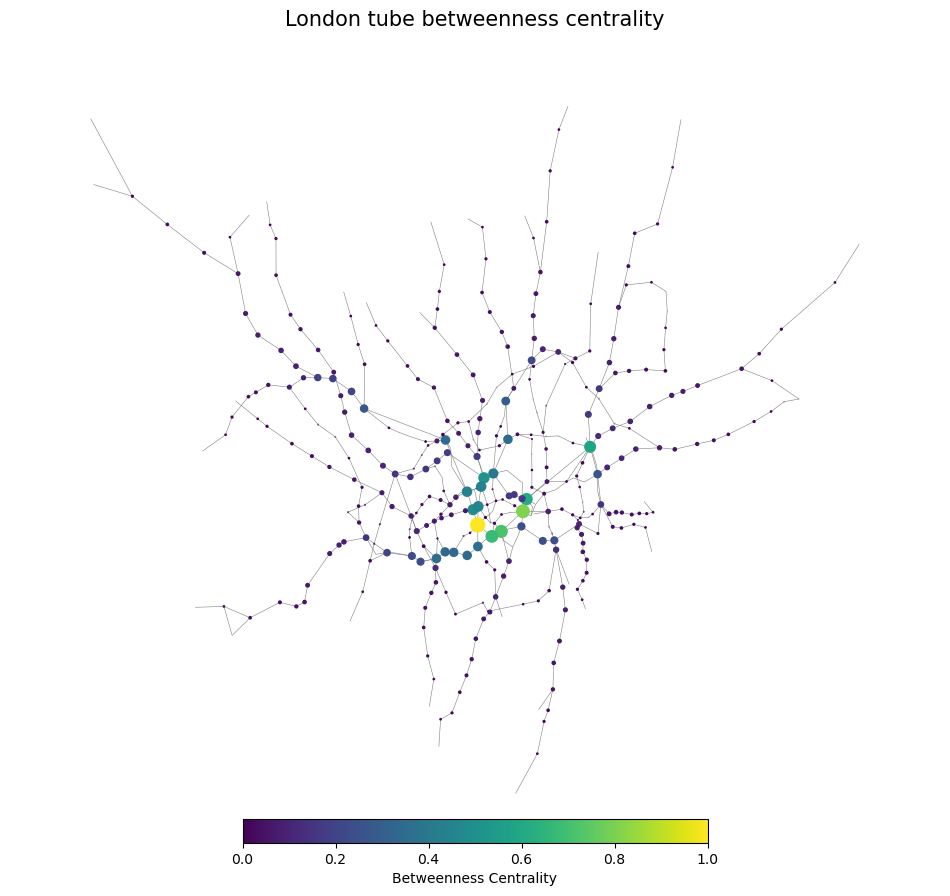

In [35]:
# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_w']) for i in G.nodes(data=True)]
#返回一个包含节点和其数据（属性）的迭代器，其中i[1]是节点数据的字典。
#从每个节点的数据字典中提取'betweenness_w'键对应的加权介数中心性值。
bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G.nodes(data=True)]
#这一行创建了一个列表bet_w_color，包含了根据加权介数中心性值相对于最大值的比例计算出的颜色值。这个比例用于表示节点在所有最短路径中的相对重要性。
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G.nodes(data=True)]
#这一行创建了一个列表bet_w_size，包含了节点大小的值，这些值基于加权介数中心性值的相对比例计算得出。
# Plot graph
pos=pos
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5,pad=-0.05)
plt.axis("off")
plt.title("London tube betweenness centrality",fontsize=15)
plt.savefig('figure/Figure 6. Weighted Betweenness centrality distribution of stations.png')
plt.show()

/tmp/ipykernel_24227/3377844091.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.5,pad=-0.05)


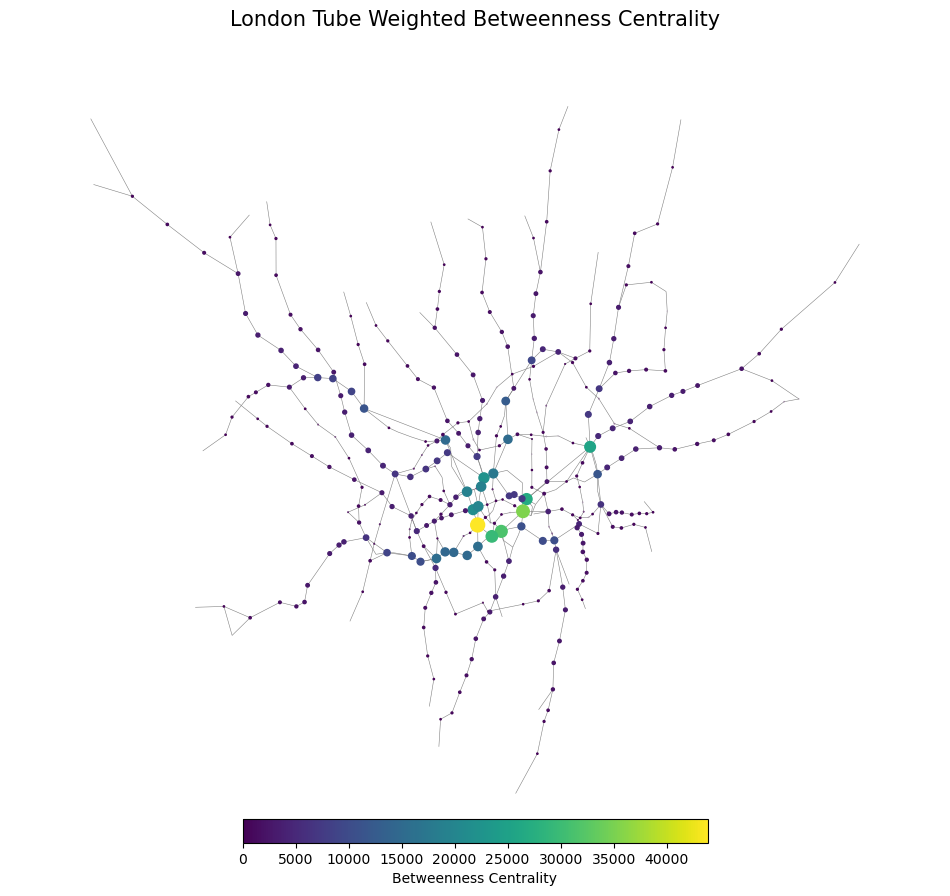

In [36]:

# Calculate betweenness centrality and assign colors and sizes based on its value
betweenness_w = nx.betweenness_centrality(G, weight='inv_flows', normalized=False)
betweenness_w_values = list(betweenness_w.values())
bet_w_color = [(value / max(betweenness_w_values)) for value in betweenness_w_values]
bet_w_size = [(value / max(betweenness_w_values) * 100) for value in betweenness_w_values]

# Plot the network
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.4)
nod = nx.draw_networkx_nodes(G, pos, node_color=bet_w_color, node_size=bet_w_size)

# Create the color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                            norm=plt.Normalize(vmin=min(betweenness_w_values), vmax=max(betweenness_w_values)))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.5,pad=-0.05)
cbar.set_label('Betweenness Centrality')

plt.axis('off')
plt.title("London Tube Weighted Betweenness Centrality", fontsize=15)
plt.savefig('figure/Figure 6. Weighted Betweenness centrality distribution of stations.png')
plt.show()

In [37]:
#Weighted closeness centrality: 
#使用权重（或距离）实际上意味着您认为边缘权重与节点之间的流量值成正比，该值可能被解释为连接强度、流量或容量，这里用作权重，这是完全有效的。
#这种使用意味着，在接近中心性计算方面，具有较高流量的路径（假设流量代表拥塞或使用情况）可能被认为是“更长”或“更昂贵”，
#这可能是一种有见地的方法，可以理解网络中节点的可访问性或重要性，其中流量代表某种形式的传输容量或使用强度。
clos_w=nx.closeness_centrality(G, distance='inv_flows')
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_w,'closeness_w')
# To ataframe using the nodes as the index
df_CW = pd.DataFrame({'station_name': list(G.nodes),
                   'closeness_w': list(clos_w.values())})
df_CW_sorted = df_CW.sort_values(by="closeness_w", ascending=False).reset_index(drop=True)
df_CW_sorted[0:11]
#这行代码使用NetworkX的closeness_centrality函数计算图G中每个节点的加权接近中心性，其中distance='length'参数指定使用节点间边的'length'属性作为距离度量。
#接近中心性衡量了一个节点到所有其他节点的平均最短路径长度；较短的平均距离表示较高的中心性。

,station_name,closeness_w
0,Green Park,2332.719879
1,Westminster,2327.541538
2,Waterloo,2322.759772
3,Bank and Monument,2321.779209
4,Oxford Circus,2312.173114
5,Bond Street,2307.691649
6,Victoria,2304.843593
7,Liverpool Street,2301.641722
8,Warren Street,2290.486858
9,Moorgate,2285.500453


/tmp/ipykernel_24227/1323569650.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.5, pad=-0.05)


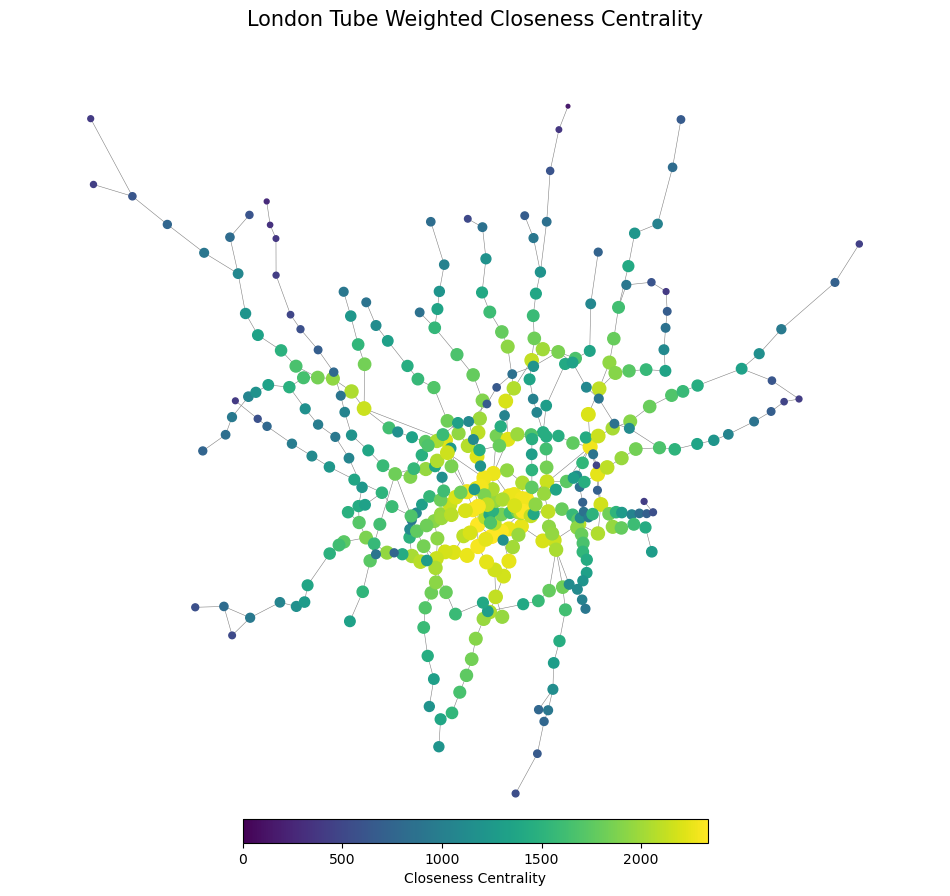

In [38]:
# Assuming 'G' is your graph and 'pos' is a dictionary of positions

# Assuming 'G' is your graph and 'pos' is a dictionary of positions

# Calculate closeness centrality and assign colors and sizes based on its value
clos_w = nx.closeness_centrality(G, distance='inv_flows')
closeness_w_values = list(clos_w.values())
clos_w_color = [(value / max(closeness_w_values)) for value in closeness_w_values]
clos_w_size = [(value / max(closeness_w_values) * 100) for value in closeness_w_values]

# Add the closeness centrality values to the node attributes
nx.set_node_attributes(G, clos_w, 'closeness_w')

# Normalize closeness values for color mapping
norm = plt.Normalize(vmin=min(closeness_w_values), vmax=max(closeness_w_values))
clos_w_color = [norm(value) for value in closeness_w_values]

# Plot the network
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.4)
nod = nx.draw_networkx_nodes(G, pos, node_color=clos_w_color, node_size=clos_w_size)

# Create the color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm._A = []  # Create an empty array for the ScalarMappable
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.5, pad=-0.05)
cbar.set_label('Closeness Centrality')
plt.axis('off')
plt.title("London Tube Weighted Closeness Centrality", fontsize=15)
plt.savefig('figure/Figure 7. Weighted closeness centrality distribution of stations.png')
plt.show()

In [26]:
# Compute weighted degree centrality
deg_london_w = nx.degree_centrality(G)

# Compute weighted betweenness centrality
bet_london_w = nx.betweenness_centrality(G, normalized=False, weight='inv_flows')

# Compute weighted closeness centrality
Clos_london_w = nx.closeness_centrality(G, distance='inv_flows')

# Combine the results into a single DataFrame
df_w = pd.DataFrame({'Station_name': list(G.nodes),
                   'Degree_w': list(deg_london_w.values()),
                   'betweenness_w': list(bet_london_w.values()),
                   'Closeness_w': list(Clos_london_w.values())})

# Sort the DataFrame by each centrality measure
df_w_degree = df_w.sort_values(by='Degree_w', ascending=False).reset_index(drop=True)
df_w_betweenness = df_w.sort_values(by='betweenness_w', ascending=False).reset_index(drop=True)
df_w_closeness = df_w.sort_values(by='Closeness_w', ascending=False).reset_index(drop=True)

# Print the top 10 stations for each centrality measure
df1_w = df_w_degree[:10][['Station_name','Degree_w']]

df2_w = df_w_betweenness[:10][['Station_name','betweenness_w']]

df3_w = df_w_closeness[:10][['Station_name','Closeness_w']]

weighted_centrality_results = pd.concat([df1_w, df2_w, df3_w], axis=1)
weighted_centrality_results

,Station_name,Degree_w,Station_name,betweenness_w,Station_name,Closeness_w
0,Stratford,0.0225,Green Park,45149.0,Green Park,2361.382127
1,Bank and Monument,0.0200,Bank and Monument,40714.0,Westminster,2353.893615
2,King's Cross St. Pancras,0.0175,Waterloo,30370.0,Waterloo,2348.908723
3,Baker Street,0.0175,Westminster,27805.0,Bank and Monument,2345.677263
4,Liverpool Street,0.0150,Liverpool Street,26879.0,Oxford Circus,2340.995545
5,Green Park,0.0150,Stratford,26424.0,Victoria,2334.656799
6,Oxford Circus,0.0150,Euston,22410.0,Bond Street,2329.955544
7,Waterloo,0.0150,Oxford Circus,21489.0,Liverpool Street,2326.696243
8,Earl's Court,0.0150,Victoria,21190.0,Warren Street,2317.586537
9,Canning Town,0.0150,Bond Street,20098.0,London Bridge,2306.922291


In [27]:
def eff_weighted(G):
    # 使用 'inv_flows' 作为路径权重来计算最短路径
    shortest_paths = dict(nx.shortest_path_length(G, weight='inv_flows'))
    for node in shortest_paths:
        shortest_paths[node] = {k: v for k, v in shortest_paths[node].items() if v != 0}
    n = len(G.nodes)
    # 有效性是基于权重路径长度的倒数的总和
    eff_w = sum(1 / d_ij for source in shortest_paths for d_ij in shortest_paths[source].values()) / (n * (n - 1))
    return eff_w

In [28]:
eff_weighted(G)

2651.357288741069

In [29]:
def average_weighted_path_length(G, weight):
    # 使用 'inv_flows' 来计算所有点对间的最短路径长度
    path_lengths = nx.all_pairs_dijkstra_path_length(G, weight='inv_flows')
    total_length = 0
    count = 0
    for _, lengths in path_lengths:
        for length in lengths.values():
            total_length += length
            count += 1
    return total_length / count if count > 0 else float('inf')

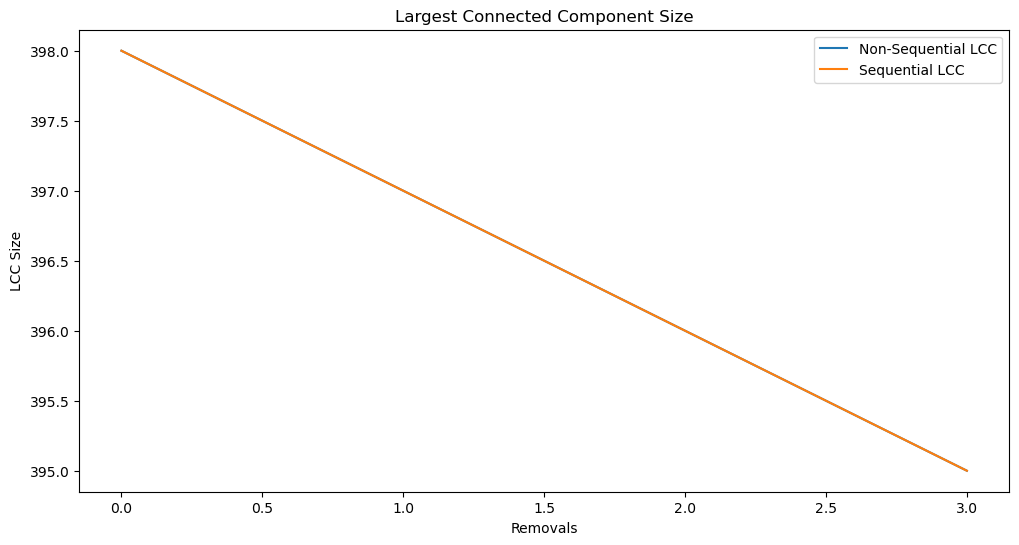

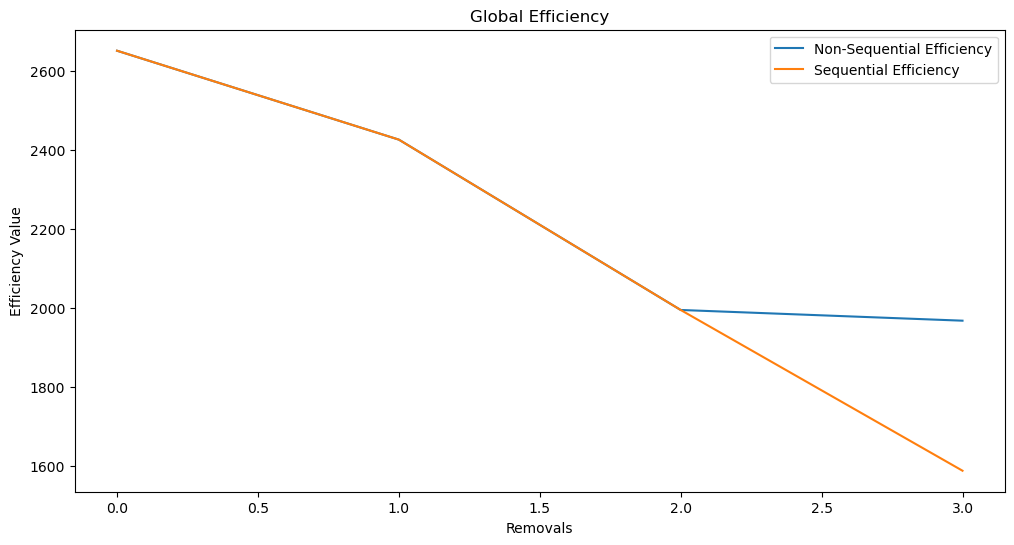

Non-Sequentially Removed Nodes: ['Green Park', 'Bank and Monument', 'Waterloo']
Sequentially Removed Nodes: ['Green Park', 'Bank and Monument', "King's Cross St. Pancras"]
Non-Sequential LCC Sizes at Removals 0, 1, 2, 3: [398, 397, 396, 395]
Non-Sequential Efficiencies at Removals 0, 1, 2, 3: [2651.357288741069, 2425.9958301583406, 1994.2485989108297, 1967.0913555452503]
Sequential LCC Sizes at Removals 0, 1, 2, 3: [398, 397, 396, 395]
Sequential Efficiencies at Removals 0, 1, 2, 3: [2651.357288741069, 2425.9958301583406, 1994.2485989108297, 1586.7990511774706]
Non-Sequentially Removed Nodes: ['Green Park', 'Bank and Monument', 'Waterloo']
Sequentially Removed Nodes: ['Green Park', 'Bank and Monument', "King's Cross St. Pancras"]


In [43]:
# Function to compute largest connected component size and global efficiency
def compute_metrics(G):
    largest_cc_size = len(max(nx.connected_components(G), key=len))  # Use connected_components for undirected graph
    n = len(G)
    efficiency = eff_weighted(G)  # No need for custom calculation, NetworkX can handle this for undirected graphs    
    return largest_cc_size, efficiency
initial_lcc, initial_eff = compute_metrics(G)
# Modify the removal functions to include the initial state
def non_sequential_removal(G, top_nodes, k=3):
    metrics = {'LCC': [initial_lcc], 'Efficiency': [initial_eff], 'Removed Nodes': []}
    for node in top_nodes[:k]:
        G.remove_node(node)
        lcc, eff = compute_metrics(G)
        metrics['LCC'].append(lcc)
        metrics['Efficiency'].append(eff)
        metrics['Removed Nodes'].append(node)
    return metrics
def sequential_removal(G, k=3):
    metrics = {'LCC': [initial_lcc], 'Efficiency': [initial_eff], 'Removed Nodes': []}
    for _ in range(k):
        bet_centrality = nx.betweenness_centrality(G, normalized=False, weight='inv_flows')
        node = max(bet_centrality, key=bet_centrality.get)
        G.remove_node(node)
        lcc, eff = compute_metrics(G)
        metrics['LCC'].append(lcc)
        metrics['Efficiency'].append(eff)
        metrics['Removed Nodes'].append(node)
    return metrics
# Get the top nodes for non-sequential removal and perform the removals
bet_centrality_w = nx.betweenness_centrality(G, normalized=False, weight='inv_flows')
top_nodes = sorted(bet_centrality_w, key=bet_centrality_w.get, reverse=True)
G_copy = G.copy()
non_seq_metrics = non_sequential_removal(G_copy, top_nodes, k=3)
# Perform sequential removal
G_copy = G.copy()
seq_metrics = sequential_removal(G_copy, k=3)
# Plotting the results on separate figures for LCC and Efficiency
# Plot for Largest Connected Component Size (LCC)
plt.figure(figsize=(12, 6))
plt.plot(non_seq_metrics['LCC'], label='Non-Sequential LCC')
plt.plot(seq_metrics['LCC'], label='Sequential LCC')
plt.title('Largest Connected Component Size')
plt.xlabel('Removals')
plt.ylabel('LCC Size')
plt.legend()
plt.show()
# Plot for Global Efficiency
plt.figure(figsize=(12, 6))
plt.plot(non_seq_metrics['Efficiency'], label='Non-Sequential Efficiency')
plt.plot(seq_metrics['Efficiency'], label='Sequential Efficiency')
plt.title('Global Efficiency')
plt.xlabel('Removals')
plt.ylabel('Efficiency Value')
plt.legend()
plt.show()
# Output the names of the removed nodes
print("Non-Sequentially Removed Nodes:", non_seq_metrics['Removed Nodes'])
print("Sequentially Removed Nodes:", seq_metrics['Removed Nodes'])

# Now we need to print out the LCC sizes and Efficiencies at removals 0, 1, 2, 3
removal_points = [0, 1, 2, 3]
lcc_non_seq_points = [non_seq_metrics['LCC'][i] for i in removal_points]
eff_non_seq_points = [non_seq_metrics['Efficiency'][i] for i in removal_points]
lcc_seq_points = [seq_metrics['LCC'][i] for i in removal_points]
eff_seq_points = [seq_metrics['Efficiency'][i] for i in removal_points]

# Printing the results
print("Non-Sequential LCC Sizes at Removals 0, 1, 2, 3:", lcc_non_seq_points)
print("Non-Sequential Efficiencies at Removals 0, 1, 2, 3:", eff_non_seq_points)
print("Sequential LCC Sizes at Removals 0, 1, 2, 3:", lcc_seq_points)
print("Sequential Efficiencies at Removals 0, 1, 2, 3:", eff_seq_points)

# Output the names of the removed nodes
print("Non-Sequentially Removed Nodes:", non_seq_metrics['Removed Nodes'])
print("Sequentially Removed Nodes:", seq_metrics['Removed Nodes'])

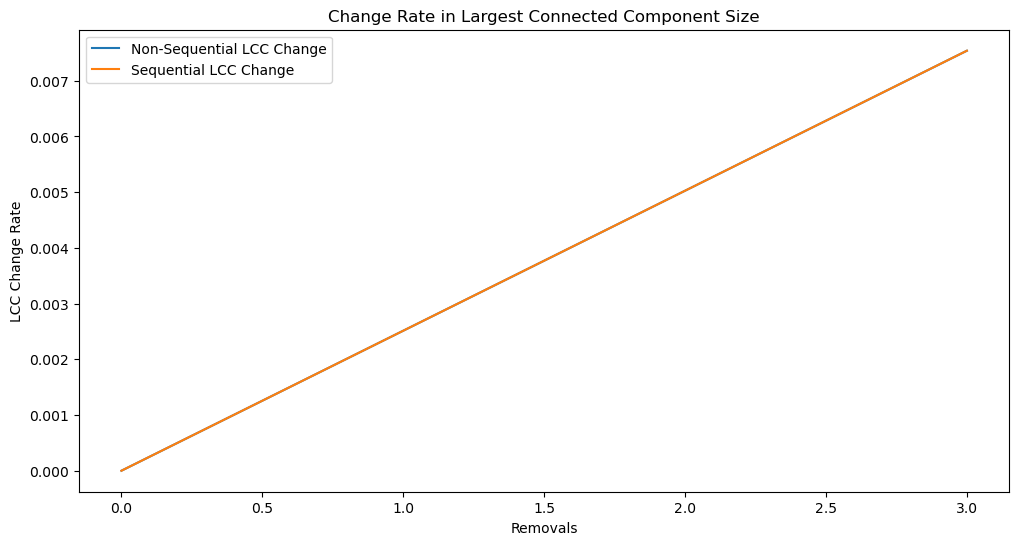

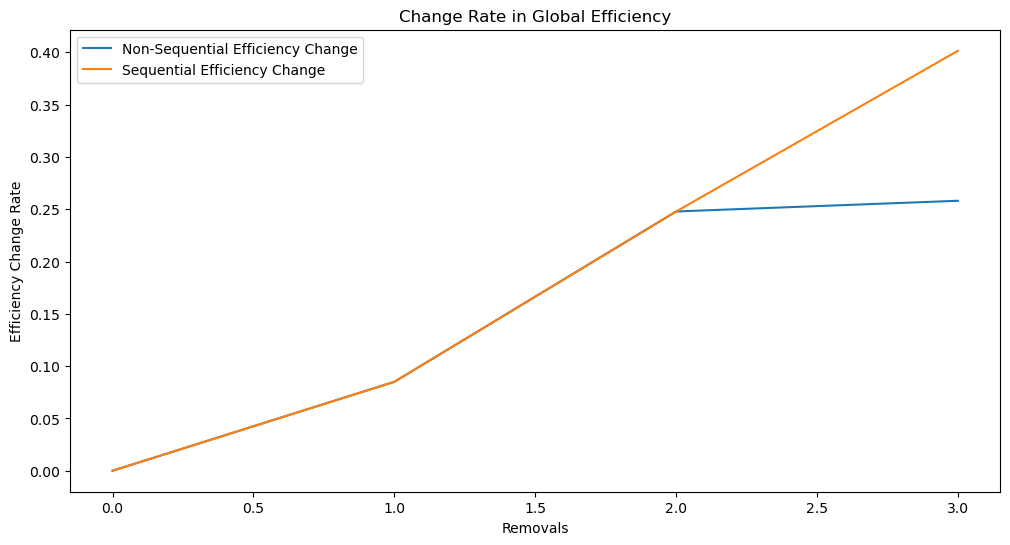

In [37]:
# Function to calculate change rates
def calculate_change_rates(initial_metric, metrics):
    return [(initial_metric - metric) / initial_metric for metric in metrics[0:]]
# Compute change rates for non-sequential removal
lcc_change_non_seq = calculate_change_rates(initial_lcc, non_seq_metrics['LCC'])
eff_change_non_seq = calculate_change_rates(initial_eff, non_seq_metrics['Efficiency'])
# Compute change rates for sequential removal
lcc_change_seq = calculate_change_rates(initial_lcc, seq_metrics['LCC'])
eff_change_seq = calculate_change_rates(initial_eff, seq_metrics['Efficiency'])
# Plotting the change rates
# LCC Change Rate
plt.figure(figsize=(12, 6))
plt.plot(lcc_change_non_seq, label='Non-Sequential LCC Change')
plt.plot(lcc_change_seq, label='Sequential LCC Change')
plt.title('Change Rate in Largest Connected Component Size')
plt.xlabel('Removals')
plt.ylabel('LCC Change Rate')
plt.legend()
plt.show()
# Efficiency Change Rate
plt.figure(figsize=(12, 6))
plt.plot(eff_change_non_seq, label='Non-Sequential Efficiency Change')
plt.plot(eff_change_seq, label='Sequential Efficiency Change')
plt.title('Change Rate in Global Efficiency')
plt.xlabel('Removals')
plt.ylabel('Efficiency Change Rate')
plt.legend()
plt.show()

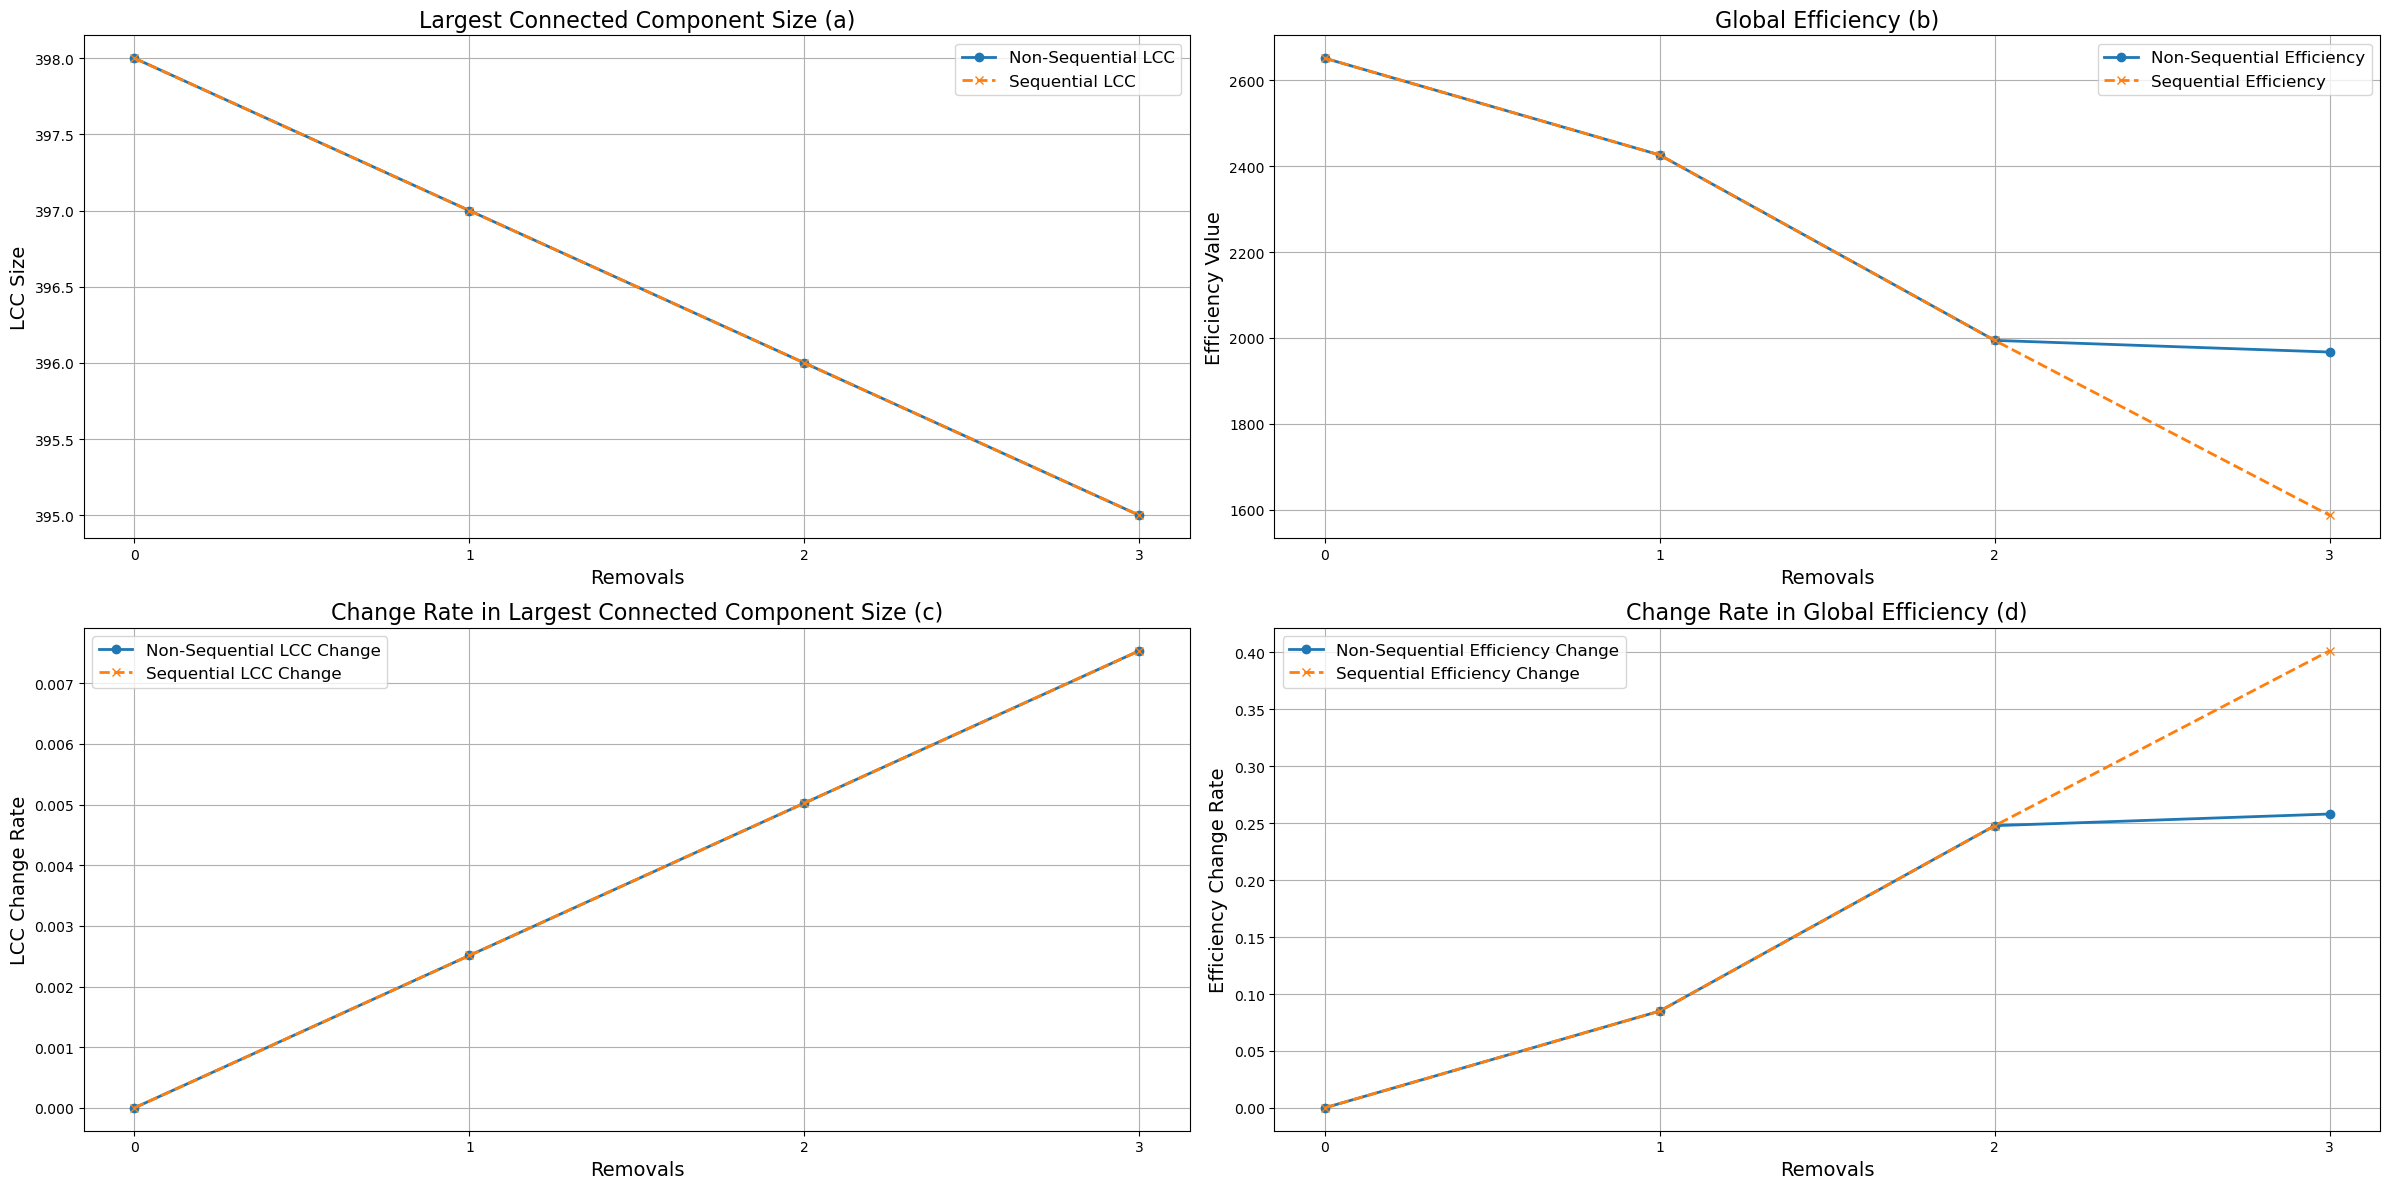

In [38]:
import matplotlib.pyplot as plt

# Constants for styling
title_fontsize = 16
label_fontsize = 14
legend_fontsize = 12
line_width = 2

# Create a large figure to accommodate all subplots
plt.figure(figsize=(24, 12))

# Subplot 1: Largest Connected Component Size (Position a)
plt.subplot(2, 2, 1)
plt.plot(non_seq_metrics['LCC'],'o-',  label='Non-Sequential LCC', linewidth=line_width)
plt.plot(seq_metrics['LCC'],linestyle='--', marker='x',label='Sequential LCC', linewidth=line_width)
plt.title('Largest Connected Component Size (a)', fontsize=title_fontsize)
plt.xlabel('Removals', fontsize=label_fontsize)
plt.xticks([0, 1, 2, 3])
plt.ylabel('LCC Size', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)

# Subplot 2: Global Efficiency (Position b)
plt.subplot(2, 2, 2)
plt.plot(non_seq_metrics['Efficiency'],'o-', label='Non-Sequential Efficiency', linewidth=line_width)
plt.plot(seq_metrics['Efficiency'],linestyle='--', marker='x', label='Sequential Efficiency', linewidth=line_width)
plt.title('Global Efficiency (b)', fontsize=title_fontsize)
plt.xlabel('Removals', fontsize=label_fontsize)
plt.xticks([0, 1, 2, 3])
plt.ylabel('Efficiency Value', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)

# Subplot 3: Change Rate in Largest Connected Component Size (Position d)
plt.subplot(2, 2, 3)
plt.plot(lcc_change_non_seq,'o-', label='Non-Sequential LCC Change', linewidth=line_width)
plt.plot(lcc_change_seq, linestyle='--', marker='x',label='Sequential LCC Change', linewidth=line_width)
plt.title('Change Rate in Largest Connected Component Size (c)', fontsize=title_fontsize)
plt.xlabel('Removals', fontsize=label_fontsize)
plt.xticks([0, 1, 2, 3])
plt.ylabel('LCC Change Rate', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)

# Subplot 4: Change Rate in Global Efficiency (Position c)
plt.subplot(2, 2, 4)
plt.plot(eff_change_non_seq,'o-', label='Non-Sequential Efficiency Change', linewidth=line_width)
plt.plot(eff_change_seq,linestyle='--', marker='x', label='Sequential Efficiency Change', linewidth=line_width)
plt.title('Change Rate in Global Efficiency (d)', fontsize=title_fontsize)
plt.xlabel('Removals', fontsize=label_fontsize)
plt.xticks([0, 1, 2, 3])
plt.ylabel('Efficiency Change Rate', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('figure/Figure 8. Impact of key stations removal on LCC and GE.png')
# Display the composite plot
plt.show()


Non-Sequentially Removed Nodes: ['Green Park', 'Bank and Monument', 'Waterloo']
Sequentially Removed Nodes: ['Green Park', 'Bank and Monument', "King's Cross St. Pancras"]


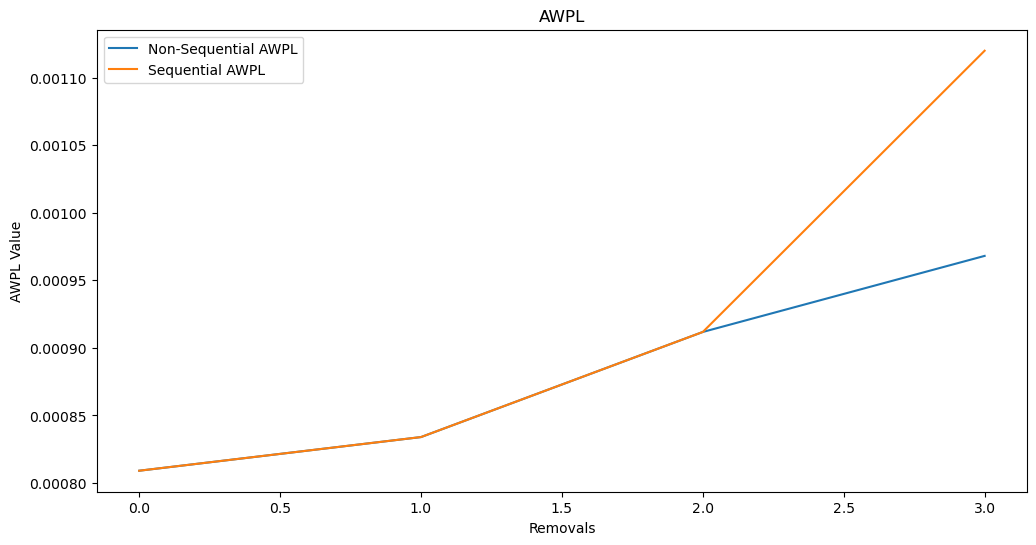

AWPL Values at Removals 0, 1, 2, 3: [0.0008090714445174764, 0.0008339852773401148, 0.000911807285902697, 0.0009681288951973914]
AWPL Values at Removals 0, 1, 2, 3: [0.0008090714445174764, 0.0008339852773401148, 0.000911807285902697, 0.0011200384910896562]


In [40]:
def removal_process(G, top_nodes, k, compute_betweenness=True):
    metrics = {
        'AWPL': [],  # Average Weighted Path Length
        'Removed Nodes': []
    }
    initial_awpl = average_weighted_path_length(G, 'inv_flows')
    metrics['AWPL'].append(initial_awpl)

    for _ in range(k):
        if compute_betweenness:
            bet_centrality = nx.betweenness_centrality(G, normalized=True, weight='inv_flows')
            node_to_remove = max(bet_centrality, key=bet_centrality.get)
        else:
            node_to_remove = top_nodes.pop(0)

        G.remove_node(node_to_remove)
        awpl = average_weighted_path_length(G, 'inv_flows')

        metrics['AWPL'].append(awpl)
        metrics['Removed Nodes'].append(node_to_remove)

    return metrics

# 使用这个函数进行无序和有序的节点删除处理
G_copy = G.copy()
non_seq_metrics = removal_process(G_copy, top_nodes[:3], k=3, compute_betweenness=False)

G_copy = G.copy()
seq_metrics = removal_process(G_copy, [], k=3, compute_betweenness=True)

# 输出和绘制结果
print("Non-Sequentially Removed Nodes:", non_seq_metrics['Removed Nodes'])
print("Sequentially Removed Nodes:", seq_metrics['Removed Nodes'])

# 绘图等操作
plt.figure(figsize=(12, 6))
plt.plot(non_seq_metrics['AWPL'], label='Non-Sequential AWPL')
plt.plot(seq_metrics['AWPL'], label='Sequential AWPL')
plt.title('AWPL')
plt.xlabel('Removals')
plt.ylabel('AWPL Value')
plt.legend()
plt.show()

# Print out the results including the change rates at specified points.

print("AWPL Values at Removals 0, 1, 2, 3:", non_seq_metrics['AWPL'][:4])

print("AWPL Values at Removals 0, 1, 2, 3:", seq_metrics['AWPL'][:4])

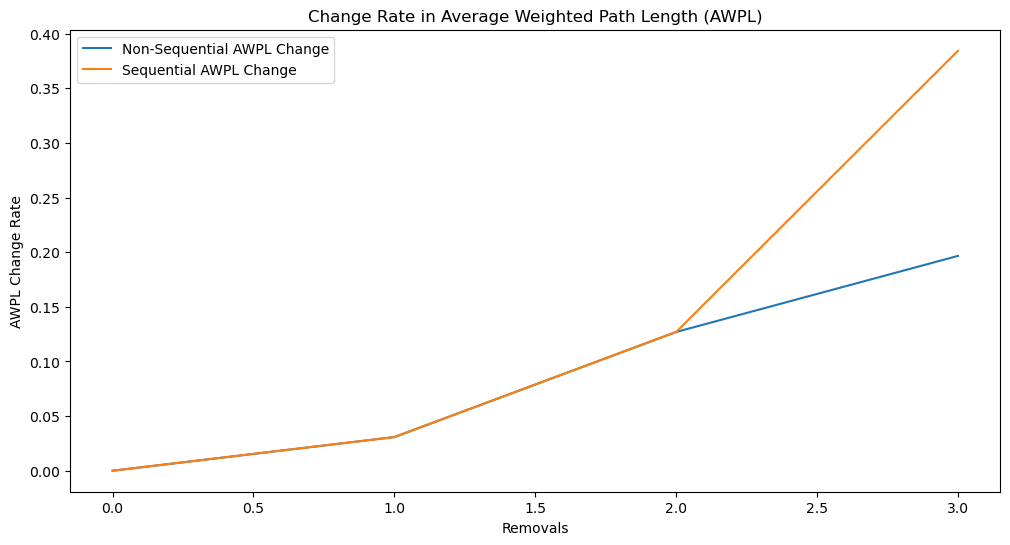

In [41]:
# Function to calculate change rates
def calculate_change_rates(initial_metric, metrics):
    return [(metric - initial_metric) / initial_metric for metric in metrics[0:]]
# Compute change rates for AWPL
awpl_change_non_seq = calculate_change_rates(non_seq_metrics['AWPL'][0], non_seq_metrics['AWPL'])
awpl_change_seq = calculate_change_rates(seq_metrics['AWPL'][0], seq_metrics['AWPL'])
# Plotting the change rates for AWPL
plt.figure(figsize=(12, 6))
plt.plot(awpl_change_non_seq, label='Non-Sequential AWPL Change')
plt.plot(awpl_change_seq, label='Sequential AWPL Change')
plt.title('Change Rate in Average Weighted Path Length (AWPL)')
plt.xlabel('Removals')
plt.ylabel('AWPL Change Rate')
plt.legend()
plt.show()


Non-Sequentially Removed Nodes: ['Green Park', 'Bank and Monument', 'Waterloo']
Sequentially Removed Nodes: ['Green Park', 'Bank and Monument', "King's Cross St. Pancras"]


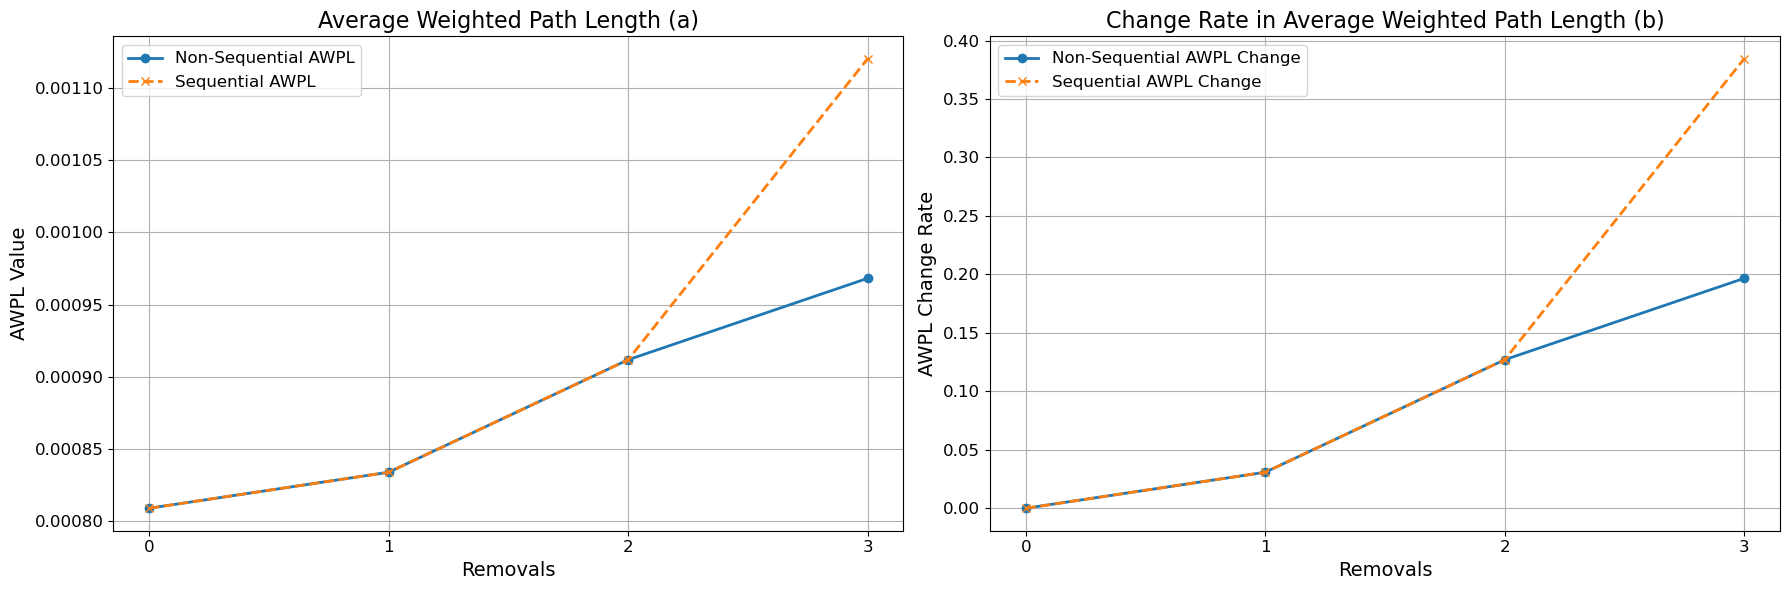

In [42]:
# Constants for styling
title_fontsize = 16
label_fontsize = 14
legend_fontsize = 12
line_width = 2
tick_labelsize = 12

# Output the names of the removed nodes
print("Non-Sequentially Removed Nodes:", non_seq_metrics['Removed Nodes'])
print("Sequentially Removed Nodes:", seq_metrics['Removed Nodes'])

# Create a figure to accommodate both subplots
plt.figure(figsize=(18, 6))

# Subplot 1: Average Weighted Path Length (AWPL)
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(non_seq_metrics['AWPL'], 'o-',label='Non-Sequential AWPL', linewidth=line_width)
plt.plot(seq_metrics['AWPL'], linestyle='--', marker='x',label='Sequential AWPL', linewidth=line_width)
plt.title('Average Weighted Path Length (a)', fontsize=title_fontsize)
plt.xlabel('Removals', fontsize=label_fontsize)
plt.xticks([0, 1, 2, 3])
plt.ylabel('AWPL Value', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.xticks(fontsize=tick_labelsize)
plt.yticks(fontsize=tick_labelsize)

# Subplot 2: Change Rate in AWPL
plt.subplot(1, 2, 2)
plt.plot(awpl_change_non_seq, 'o-',label='Non-Sequential AWPL Change', linewidth=line_width)
plt.plot(awpl_change_seq, linestyle='--',marker='x',label='Sequential AWPL Change', linewidth=line_width)
plt.title('Change Rate in Average Weighted Path Length (b)', fontsize=title_fontsize)
plt.xlabel('Removals', fontsize=label_fontsize)
plt.ylabel('AWPL Change Rate', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.xticks(fontsize=tick_labelsize)
plt.xticks([0, 1, 2, 3])
plt.yticks(fontsize=tick_labelsize)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('figure/Figure 9. Impact of key stations removal on AWPL.png')
# Display the composite plot
plt.show()